# Factors Contributing to U.S. Traffic Accidents

## Overview
This project analyzes a comprehensive dataset of U.S. traffic accidents to identify the key infrastructure and environmental factors that contribute to accident severity. The goal is to provide the Department of Transportation (DOT) with actionable, data-driven recommendations to enhance road safety and optimize emergency response.

Key Insights (BLUF)
While features like traffic signals and crossings are significantly associated with a lower percentage of fatal (Severity 4) accidents, controls like stop signs and roundabouts show no statistical impact on reducing the most severe incidents. This suggests a need to prioritize high-impact infrastructure.

The most dangerous conditions can seem obvious but often are not. Darkness and snowy conditions show the most significant increase in the proportion of fatal accidents. Surprisingly, conditions like rain and fog are less associated with severe outcomes, likely due to heightened driver caution.

Junctions are critical hotspots for severe accidents. The presence of a junction is associated with a notable increase in the likelihood of a fatal accident, identifying these areas as prime targets for safety reviews and engineering improvements.

## Business Understanding

Key Questions:

Which controllable POI feature has the highest impact on the most severe accidents?

Which weather condition is most associated with the severity of accidents?

Do the most severe accidents occur in certain light conditions?

This project analyzes the key factors present in the most severe traffic accidents across the United States. As accidents are a leading cause of death, identifying these factors is critical for saving lives. Our primary goal is to provide the Department of Transportation (DOT) Safety Board with actionable insights by examining two types of conditions: controllable factors, such as road infrastructure, to recommend direct safety interventions; and uncontrollable factors, like weather, to help emergency services improve their preparedness and response times.

## Data Understanding

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import scipy
import statsmodels
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, split, regexp_replace, to_timestamp, avg, isnan, count, percentile_approx, hour, row_number, trim
from pyspark.sql.window import Window

In [2]:
# Start Spark session
spark = SparkSession.builder \
    .appName("BigJob") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

# Load CSV file into Spark DataFrame
path = 'Data/US_Accidents_March23.csv'
df = spark.read.option("header", "true").option("inferSchema", "true").csv(path)

In [3]:
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [4]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [5]:
df.describe().show()

+-------+--------+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+------------------+----------+---------+-------+------------------+-------+----------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID| Source|          Severity|        Start_Lat|         Start_Lng|          End_Lat|           End_Lng|      Distance(mi)|         Description|            Street|      City|   County|  State|           Zipcode|Country|  Timezone|Airport_Code|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)| Weather_Condition|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+-------+-

#### Data columns - those left out were self explanatory or expected to be dropped

'Severity' - Shows the severity of the accident, 1-4 where 1 is low. Could be binning from end-start time

'Start_Time' - Shows start time of the accident in local time zone.

'End_Time' - Shows end time of the accident in local time zone. When traffic flow was dismissed.

'Start_Lat' - latitude start point

'Start_Lng' - longitude start point

'End_Lat' - latitude end point (many missing values)

'End_Lng' - longitude end point (many missing values, same as lat)

'Distance(mi)' - The length of the road extent affected by the accident in miles.

'Description' - description of the accident.

'Airport_Code' - airport-based weather station which is the closest one to location of the accident

'Weather_Condition' - 145 unique weather descriptions

'Amenity' to 'Turning_Loop' - indicates presence of x in a nearby location, boolean

'Sunrise_Sunset' - period of day (i.e. day or night) based on sunrise/sunset, (day or night)

'Civil_Twilight' - period of day (i.e. day or night) based on civil twilight (basically sun is below horizon but its still bright)

'Nautical_Twilight' - period of day (i.e. day or night) based on nautical twilight, less light than civil but more than Astronomical

'Astronomical_Twilight' - period of day (i.e. day or night) based on astronomical twilight, essentially night at this point

## Data Preparation

In [6]:
#I added this after the data prep phase. Put it up here to get rid of columns that proved to not be needed and help memory.
cols_to_drop = [
    'ID', 'Source', 'Description', 'Street', 'City', 'Country',
    'Timezone', 'Weather_Timestamp', 'Sunrise_Sunset',
    'Wind_Direction', 'Nautical_Twilight'
]
df = df.drop(*cols_to_drop)

In [7]:
df = df.withColumn("Start_Time_clean", to_timestamp(split(col("Start_Time").cast("string"), "\\.").getItem(0)))
df = df.withColumn("End_Time_clean", to_timestamp(split(col("End_Time").cast("string"), "\\.").getItem(0)))

In [8]:
sampled = df.select("Start_Time", "End_Time", "Start_Time_clean", "End_Time_clean").sample(False, 0.001, seed=42)
sampled.show(20)

+-------------------+-------------------+-------------------+-------------------+
|         Start_Time|           End_Time|   Start_Time_clean|     End_Time_clean|
+-------------------+-------------------+-------------------+-------------------+
|2016-12-15 17:27:42|2016-12-15 17:57:15|2016-12-15 17:27:42|2016-12-15 17:57:15|
|2016-12-16 02:56:06|2016-12-16 03:40:46|2016-12-16 02:56:06|2016-12-16 03:40:46|
|2016-12-18 12:59:03|2016-12-18 13:28:49|2016-12-18 12:59:03|2016-12-18 13:28:49|
|2016-12-23 02:19:39|2016-12-23 03:04:20|2016-12-23 02:19:39|2016-12-23 03:04:20|
|2016-12-29 15:50:03|2016-12-29 16:19:22|2016-12-29 15:50:03|2016-12-29 16:19:22|
|2017-01-04 14:54:25|2017-01-04 15:24:00|2017-01-04 14:54:25|2017-01-04 15:24:00|
|2017-01-05 20:47:29|2017-01-05 21:17:16|2017-01-05 20:47:29|2017-01-05 21:17:16|
|2017-01-12 08:29:58|2017-01-12 09:12:06|2017-01-12 08:29:58|2017-01-12 09:12:06|
|2017-01-13 21:30:45|2017-01-13 22:00:29|2017-01-13 21:30:45|2017-01-13 22:00:29|
|2017-01-18 19:1

In [9]:
# Get total number of rows
total_rows = df.count()

# Calculate % missing values
missing_exprs = [
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in df.columns
]

# Create wide format missing table
missing_df = df.select(missing_exprs)

# Convert to long format and filter > 0
missing_percent = (
    missing_df.selectExpr("stack(" + str(len(df.columns)) + "," +
        ",".join([f"'{c}', `{c}`" for c in df.columns]) +
        ") as (column, percent)")
    .filter("percent > 0")
    .orderBy("percent", ascending=False)
)

missing_percent.show(truncate=False)

+---------------------+--------------------+
|column               |percent             |
+---------------------+--------------------+
|End_Lat              |44.02935461106149   |
|End_Lng              |44.02935461106149   |
|Precipitation(in)    |28.512857910712107  |
|Wind_Chill(F)        |25.86590435218494   |
|Wind_Speed(mph)      |7.391354529802699   |
|Visibility(mi)       |2.291523956982524   |
|Humidity(%)          |2.253301268025414   |
|Weather_Condition    |2.244437848277404   |
|Temperature(F)       |2.1201429430228327  |
|Pressure(in)         |1.820287630263157   |
|Civil_Twilight       |0.30078694228063424 |
|Astronomical_Twilight|0.30078694228063424 |
|Airport_Code         |0.2928810306513876  |
|Zipcode              |0.024778757397720667|
+---------------------+--------------------+



In [10]:
#possible that end lat/lng is null where the accident started and ended at the same location
df = df.withColumn("End_Lat", when(col("End_Lat").isNull(), col("Start_Lat")).otherwise(col("End_Lat")))
df = df.withColumn("End_Lng", when(col("End_Lng").isNull(), col("Start_Lng")).otherwise(col("End_Lng")))

I do not see a good way to infer values for endpoint, especially considering the Distance column is not measuring the same thing. We can maybe assume the accident ended in the same place it started. Will infer starting lat/long where end is null and possibly create a column for change later

In [11]:
df = df.withColumn("Precipitation(in)", when(col("Precipitation(in)").isNull(), 0).otherwise(col("Precipitation(in)")))

In [12]:
#If wind chill is nan, we'll infer the temp. However there are some temps that are null so let's handle that first
#For temp, let's infer median temp by state
window = Window.partitionBy("State")
df = df.withColumn("Temperature(F)", when(
    col("Temperature(F)").isNull(),
    avg("Temperature(F)").over(window)
).otherwise(col("Temperature(F)")))

In [13]:
temp_diff = df.select((col("Temperature(F)") - col("Wind_Chill(F)")).alias("diff")) \
              .where(col("Wind_Chill(F)").isNotNull()) \
              .agg(avg("diff").alias("avg_diff")).first()["avg_diff"]

In [14]:
df = df.withColumn("Wind_Chill(F)", when(
    col("Wind_Chill(F)").isNull(),
    col("Temperature(F)") - temp_diff
).otherwise(col("Wind_Chill(F)")))

Next let's deal with Weather_Condition as it could help with null values in 

Wind_Speed(mph), Visibility(mi), Wind_Direction, Humidity(%), Pressure(in)

In [15]:
df.select("Weather_Condition").distinct().show(truncate=False)

+----------------------------+
|Weather_Condition           |
+----------------------------+
|Ice Pellets                 |
|Shallow Fog                 |
|Thunderstorm                |
|Volcanic Ash                |
|N/A Precipitation           |
|Showers in the Vicinity     |
|Cloudy                      |
|Light Freezing Rain         |
|Blowing Snow                |
|Heavy Rain / Windy          |
|Low Drifting Snow           |
|Heavy Thunderstorms and Snow|
|Widespread Dust             |
|Snow Grains                 |
|Light Rain with Thunder     |
|Squalls                     |
|Scattered Clouds            |
|Heavy T-Storm               |
|Patches of Fog              |
|Rain Showers                |
+----------------------------+
only showing top 20 rows



In [16]:
df = df.withColumn(
    "Weather_Condition",
    when(col("Weather_Condition").isNull(), "Unknown").otherwise(col("Weather_Condition"))
)

In [17]:
#This mapping is not perfect but should give reasonable categorical features for weather conditions
# Flatten  dictionary
weather_map = {
    'Fair': ['Fair', 'Fair / Windy'],
    'Mostly Cloudy': ['Mostly Cloudy', 'Mostly Cloudy / Windy'],
    'Cloudy': ['Cloudy', 'Cloudy / Windy'],
    'Clear': ['Clear'],
    'Partly Cloudy': ['Partly Cloudy', 'Partly Cloudy / Windy'],
    'Overcast': ['Overcast'],
    'Light Rain': [
        'Light Rain', 'Light Rain Showers', 'Light Rain Shower', 'Light Rain / Windy',
        'Light Drizzle', 'Light Drizzle / Windy', 'Drizzle', 'Drizzle / Windy',
        'Heavy Drizzle', 'Light Rain with Thunder', 'Rain Shower', 'Rain Shower / Windy',
        'Showers in the Vicinity'
    ],
    'Scattered Clouds': ['Scattered Clouds'],
    'Light Snow': [
        'Light Snow', 'Light Snow Showers', 'Light Snow Shower', 'Light Snow / Windy',
        'Light Snow and Sleet', 'Light Snow and Sleet / Windy', 'Light Snow with Thunder',
        'Light Snow Grains', 'Light Sleet', 'Light Sleet / Windy', 'Light Ice Pellets',
        'Light Hail', 'Light Thunderstorms and Snow'
    ],
    'Fog': [
        'Fog', 'Shallow Fog', 'Fog / Windy', 'Shallow Fog / Windy', 'Patchy Fog',
        'Patches of Fog', 'Patches of Fog / Windy', 'Partial Fog', 'Partial Fog / Windy',
        'Light Fog', 'Mist', 'Mist / Windy', 'Light Haze', 'Haze', 'Haze / Windy',
        'Smoke', 'Smoke / Windy'
    ],
    'Rain': [
        'Rain', 'Rain / Windy', 'Rain Showers', 'Rain Shower', 'Heavy Rain',
        'Heavy Rain Showers', 'Heavy Rain Showers / Windy', 'Heavy Rain / Windy',
        'Heavy Rain Shower / Windy', 'Heavy Rain Shower', 'Heavy Thunderstorms and Rain',
        'Thunderstorms and Rain', 'T-Storm', 'T-Storm / Windy', 'Thunder',
        'Thunder / Windy', 'Thunderstorm', 'Thunder in the Vicinity', 'Thunder and Hail',
        'Thunder and Hail / Windy', 'Thunder / Wintry Mix', 'Thunder / Wintry Mix / Windy',
        'Thunderstorms and Snow', 'Heavy Thunderstorms and Snow',
        'Thunderstorms with Small Hail', 'Heavy Thunderstorms with Small Hail',
        'Light Thunderstorm'
    ]
}

# Create reverse map: condition → category
condition_to_category = {condition: category for category, conditions in weather_map.items() for condition in conditions}

# Column logic
weather_category_col = when(col("Weather_Condition").isNull(), "Unknown")

for condition, category in condition_to_category.items():
    weather_category_col = weather_category_col.when(col("Weather_Condition") == condition, category)

weather_category_col = weather_category_col.otherwise("Other")

# Add the new column to the DataFrame
df = df.withColumn("Weather_Category", weather_category_col)

In [18]:
df.select("Weather_Category").distinct().orderBy("Weather_Category").show(truncate=False)

+----------------+
|Weather_Category|
+----------------+
|Clear           |
|Cloudy          |
|Fair            |
|Fog             |
|Light Rain      |
|Light Snow      |
|Mostly Cloudy   |
|Other           |
|Overcast        |
|Partly Cloudy   |
|Rain            |
|Scattered Clouds|
+----------------+



for Wind_Speed(mph), Visibility(mi), Humidity(%), and Pressure(in), we'll use median values grouped by weather condition

In [19]:
# Columns to impute
weather_columns = [
    'Wind_Speed(mph)', 
    'Visibility(mi)',
    'Humidity(%)', 
    'Pressure(in)'
]

# Loop through columns and fill missing values by group median
for col_name in weather_columns:
    # Median per weather category
    median_col = f"{col_name}_median"
    window = Window.partitionBy("Weather_Category")
    
    df = df.withColumn(
        median_col, 
        percentile_approx(col(col_name), 0.5, 100).over(window)
    )
    
    df = df.withColumn(
        col_name,
        when(col(col_name).isNull(), col(median_col)).otherwise(col(col_name))
    ).drop(median_col)

We have missing values for sunset/twilight. The ultimate goal here is to gauge how dark it was at the time of the accident. To do this, we want to end up with a column with three unique values: light, dark, and twilight. We can say its light if Civil_twilight == day, dark if astronomical == night, and twilight if civil == night and astronomical == day. For missing values, we'll use the most common value after grouping by start time hour

In [20]:
# Step 1: Extract Hour
df = df.withColumn("Hour", hour("Start_Time"))

# Step 2: For each twilight column, fill nulls with mode per hour
twilight_cols = ['Astronomical_Twilight', 'Civil_Twilight']

for twilight_col in twilight_cols:
    # Calculate mode (most frequent value) per hour
    mode_df = df.groupBy("Hour", twilight_col).count()
    
    # Rank within hour by count descending
    mode_window = Window.partitionBy("Hour").orderBy(col("count").desc())
    
    mode_ranked = mode_df.withColumn("rank", row_number().over(mode_window)) \
                         .filter(col("rank") == 1) \
                         .select("Hour", col(twilight_col).alias(f"{twilight_col}_mode"))

    # Join back with main DataFrame
    df = df.join(mode_ranked, on="Hour", how="left")

    # Fill missing values
    df = df.withColumn(
        twilight_col,
        when(col(twilight_col).isNull(), col(f"{twilight_col}_mode")).otherwise(col(twilight_col))
    ).drop(f"{twilight_col}_mode")

In [21]:
df = df.withColumn(
    "Light_Condition",
    when((col("Civil_Twilight") == "Day"), "Light")
    .when((col("Civil_Twilight") == "Night") & (col("Astronomical_Twilight") == "Night"), "Dark")
    .when((col("Civil_Twilight") == "Night") & (col("Astronomical_Twilight") == "Day"), "Twilight")
    .otherwise("Unknown")
)

In [22]:
df.groupBy("Light_Condition").count().orderBy("count", ascending=False).show(truncate=False)

+---------------+-------+
|Light_Condition|count  |
+---------------+-------+
|Light          |5712632|
|Dark           |1326699|
|Twilight       |689063 |
+---------------+-------+



For location data, I think we ultimately want two classifications. First we want a general regional representation, then we want some representation of how urban/rural the area is. I have downloaded the https://www.cdc.gov/nchs/data/data-analysis/NCHSurb-rural-codes.csv found here: https://www.cdc.gov/nchs/data-analysis-tools/urban-rural.html?CDC_AAref_Val=https://www.cdc.gov/nchs/data_access/urban_rural.htm .


In [23]:
urban_df = spark.read.option("header", "true") \
                     .option("encoding", "iso-8859-1") \
                     .csv("Data/NCHSurb-rural-codes.csv")

In [24]:
urban_df.show(5)

+------+-------+---------+--------------+--------------------+-------+------+--------+--------+--------+--------+
|STFIPS|CTYFIPS|ST_ABBREV|       CTYNAME|           CBSATITLE|CBSAPOP|CTYPOP|CODE2023|CODE2013|CODE2006|CODE1990|
+------+-------+---------+--------------+--------------------+-------+------+--------+--------+--------+--------+
|     1|      1|       AL|Autauga County|      Montgomery, AL| 385460| 59759|       3|       3|       3|       3|
|     1|      3|       AL|Baldwin County|Daphne-Fairhope-F...| 246435|246435|       4|       4|       5|       3|
|     1|      5|       AL|Barbour County|      Eufaula, AL-GA|  26955| 24706|       5|       6|       5|       5|
|     1|      7|       AL|   Bibb County|      Birmingham, AL|1181196| 22005|       2|       2|       2|       6|
|     1|      9|       AL| Blount County|      Birmingham, AL|1181196| 59512|       2|       2|       2|       3|
+------+-------+---------+--------------+--------------------+-------+------+--------+--

In [25]:
# Step 1: Strip and clean strings in both dataframes
df = df.withColumn("State", trim(col("State")))
df = df.withColumn("County", trim(col("County")))

urban_df = urban_df.withColumn("ST_ABBREV", trim(col("ST_ABBREV")))
urban_df = urban_df.withColumn("CTYNAME", trim(col("CTYNAME")))
urban_df = urban_df.withColumn("CTYNAME", regexp_replace("CTYNAME", " County", ""))

# Step 2: Join on standardized county and state
df = df.join(
    urban_df.select("ST_ABBREV", "CTYNAME", "CODE2023"),
    (df["State"] == urban_df["ST_ABBREV"]) & (df["County"] == urban_df["CTYNAME"]),
    how="left"
)

In [26]:
df.filter(col("CODE2023").isNull()) \
  .select("ST_ABBREV", "CTYNAME", "CODE2023", "State", "County") \
  .dropDuplicates() \
  .orderBy("ST_ABBREV", "CTYNAME", "CODE2023", "State", "County") \
  .show(truncate=False)

+---------+-------+--------+-----+------------------------------+
|ST_ABBREV|CTYNAME|CODE2023|State|County                        |
+---------+-------+--------+-----+------------------------------+
|NULL     |NULL   |NULL    |AL   |De Kalb                       |
|NULL     |NULL   |NULL    |AL   |Dekalb                        |
|NULL     |NULL   |NULL    |AL   |Saint Clair                   |
|NULL     |NULL   |NULL    |AL   |St Clair                      |
|NULL     |NULL   |NULL    |AR   |St Francis                    |
|NULL     |NULL   |NULL    |CT   |Capitol                       |
|NULL     |NULL   |NULL    |CT   |Greater Bridgeport            |
|NULL     |NULL   |NULL    |CT   |Lower Connecticut River Valley|
|NULL     |NULL   |NULL    |CT   |Naugatuck Valley              |
|NULL     |NULL   |NULL    |CT   |Northeastern Connecticut      |
|NULL     |NULL   |NULL    |CT   |Northwest Hills               |
|NULL     |NULL   |NULL    |CT   |South Central Connecticut     |
|NULL     

In [27]:
# Total number of rows
total_rows = df.count()

# Number of null CODE2023 entries
missing_code2023 = df.filter(col("CODE2023").isNull()).count()

print(f"Missing CODE2023: {missing_code2023} out of {total_rows} rows")
#Significant missing values, maybe we can infer from airport code once we sort out the missing values there

Missing CODE2023: 416347 out of 7728394 rows


In [28]:
# Number of null entries
missing_Airport_Code = df.filter(col("Airport_Code").isNull()).count()

print(f"Missing Airport_Code: {missing_Airport_Code} out of {total_rows} rows")

Missing Airport_Code: 22635 out of 7728394 rows


In [29]:
#Fill missing Airport_Code
# Step 1: Count how many times each Airport_Code appears per Zipcode
mode_df = df.groupBy("Zipcode", "Airport_Code").count()

# Step 2: Rank Airport_Codes by frequency within each Zipcode
zip_window = Window.partitionBy("Zipcode").orderBy(col("count").desc())

mode_df = mode_df.withColumn("rank", row_number().over(zip_window)) \
                 .filter(col("rank") == 1) \
                 .select("Zipcode", col("Airport_Code").alias("Most_Common_Airport"))

# Step 3: Join the most common Airport_Code back to original DataFrame
df = df.join(mode_df, on="Zipcode", how="left")

# Step 4: Fill missing Airport_Code
df = df.withColumn(
    "Airport_Code",
    when(col("Airport_Code").isNull(), col("Most_Common_Airport")).otherwise(col("Airport_Code"))
).drop("Most_Common_Airport")

In [30]:
missing_Airport_Code = df.filter(col("Airport_Code").isNull()).count()

print(f"Missing Airport_Code: {missing_Airport_Code} out of {total_rows} rows")

Missing Airport_Code: 22635 out of 7728394 rows


In [31]:
#Repeat with state now
# Step 1: Count how many times each Airport_Code appears per state
mode_df = df.groupBy("State", "Airport_Code").count()

# Step 2: Rank Airport_Codes by count within each State
state_window = Window.partitionBy("State").orderBy(col("count").desc())

mode_df = mode_df.withColumn("rank", row_number().over(state_window)) \
                 .filter(col("rank") == 1) \
                 .select("State", col("Airport_Code").alias("Most_Common_Airport"))

# Step 3: Join back and impute
df = df.join(mode_df, on="State", how="left")

df = df.withColumn(
    "Airport_Code",
    when(col("Airport_Code").isNull(), col("Most_Common_Airport")).otherwise(col("Airport_Code"))
).drop("Most_Common_Airport")

In [32]:
missing_Airport_Code = df.filter(col("Airport_Code").isNull()).count()

print(f"Missing Airport_Code: {missing_Airport_Code} out of {total_rows} rows")

Missing Airport_Code: 0 out of 7728394 rows


In [33]:
#Fill by most common zipcode, then state. This fixed all nulls. Now infer code2023 based off airport_code
# Step 1: Filter rows with non-null CODE2023 for mode calculation
non_null_df = df.filter(col("CODE2023").isNotNull())

# Step 2: Compute mode per Airport_Code
airport_mode = non_null_df.groupBy("Airport_Code", "CODE2023").count()

# Step 3: Rank modes by count (break ties with CODE2023 for determinism)
window = Window.partitionBy("Airport_Code").orderBy(col("count").desc(), col("CODE2023"))
airport_mode = airport_mode.withColumn("rank", row_number().over(window)) \
                           .filter(col("rank") == 1) \
                           .select("Airport_Code", col("CODE2023").alias("Most_Common_CODE2023"))

# Step 4: Join back to all df (even if CODE2023 is null there)
df = df.join(airport_mode, on="Airport_Code", how="left")

# Step 5: Fill nulls
df = df.withColumn(
    "CODE2023",
    when(col("CODE2023").isNull(), col("Most_Common_CODE2023")).otherwise(col("CODE2023"))
).drop("Most_Common_CODE2023")

In [34]:
missing_CODE2023 = df.filter(col("CODE2023").isNull()).count()

print(f"Missing CODE2023: {missing_CODE2023} out of {total_rows} rows")

Missing CODE2023: 222864 out of 7728394 rows


In [35]:
# Step 1: Filter only rows with non-null CODE2023 for mode computation
non_null_state_df = df.filter(col("CODE2023").isNotNull())

# Step 2: Count occurrences of CODE2023 per State
state_mode = non_null_state_df.groupBy("State", "CODE2023").count()

# Step 3: Rank by frequency within each State (with tie-breaker on CODE2023)
state_window = Window.partitionBy("State").orderBy(col("count").desc(), col("CODE2023"))

state_mode = state_mode.withColumn("rank", row_number().over(state_window)) \
                       .filter(col("rank") == 1) \
                       .select("State", col("CODE2023").alias("Most_Common_CODE2023"))

# Step 4: Join mode back to full DataFrame
df = df.join(state_mode, on="State", how="left")

# Step 5: Impute nulls using state-level mode
df = df.withColumn(
    "CODE2023",
    when(col("CODE2023").isNull(), col("Most_Common_CODE2023")).otherwise(col("CODE2023"))
).drop("Most_Common_CODE2023")

In [36]:
missing_CODE2023 = df.filter(col("CODE2023").isNull()).count()

print(f"Missing CODE2023: {missing_CODE2023} out of {total_rows} rows")

Missing CODE2023: 0 out of 7728394 rows


In [37]:
# Calculate % missing values again
missing_exprs = [
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in df.columns
]

# Create wide format missing table
missing_df = df.select(missing_exprs)

# Convert to long format and filter > 0
missing_percent = (
    missing_df.selectExpr("stack(" + str(len(df.columns)) + "," +
        ",".join([f"'{c}', `{c}`" for c in df.columns]) +
        ") as (column, percent)")
    .filter("percent > 0")
    .orderBy("percent", ascending=False)
)

missing_percent.show(truncate=False)

+---------+--------------------+
|column   |percent             |
+---------+--------------------+
|ST_ABBREV|4.621205906427648   |
|CTYNAME  |4.621205906427648   |
|Zipcode  |0.024778757397720667|
+---------+--------------------+



In [38]:
df = df.drop("ST_ABBREV", "CTYNAME", "Zipcode", 'Civil_Twilight', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'County', 'State', 
             'Astronomical_Twilight', 'Hour', 'Duration_minutes', 'Duration', 'End_Time_clean', 'Start_Time', 'End_Time', 'Weather_Condition')

In [39]:
df.columns

['Airport_Code',
 'Severity',
 'Distance(mi)',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Start_Time_clean',
 'Weather_Category',
 'Light_Condition',
 'CODE2023']

In [42]:
# Get number of partitions
num_partitions = 8

# Collect partitioned Pandas chunks
pdf_parts = []

for i in range(num_partitions):
    print(f"Processing partition {i+1}/{num_partitions}...")
    # Get only the ith partition as a DataFrame
    part_df = df.rdd \
        .mapPartitionsWithIndex(lambda idx, it: it if idx == i else []) \
        .toDF()

    # Convert that small Spark DataFrame to Pandas
    pdf_chunk = part_df.toPandas()
    pdf_parts.append(pdf_chunk)

# Concatenate all Pandas chunks into one
pdf = pd.concat(pdf_parts, ignore_index=True)

Processing partition 1/8...
Processing partition 2/8...
Processing partition 3/8...
Processing partition 4/8...
Processing partition 5/8...
Processing partition 6/8...
Processing partition 7/8...
Processing partition 8/8...


In [43]:
df.unpersist()
del df
spark.stop()

In [ ]:
pdf.to_parquet("intermediate/pdf_checkpoint.parquet")

Checkpoint if kernal crashed

In [3]:
pdf = pd.read_parquet("intermediate/pdf_checkpoint.parquet")

The initial scope of this project involved a broad analysis, preparing the complete dataset for a logistic regression model to identify key features of accident severity. This included feature engineering including cyclical transformation of date/time features and adding a Urban-Rural rating to the set. To provide more direct and interpretable insights, and considering the limitations of resources available, the methodology was refined to focus on targeted statistical testing of specific high-impact features. While this focused approach does not use every prepared variable, the comprehensive data cleaning ensures the integrity and usability of the dataset for any future analysis.

## Analysis

In [ ]:
pdf['DayOfWeek'] = pdf['Start_Time_clean'].dt.day_name()  
pdf['Month'] = pdf['Start_Time_clean'].dt.month_name()    
pdf['Hour'] = pdf['Start_Time_clean'].dt.hour     

In [ ]:
pdf.drop(columns=['Turning_Loop'], inplace=True)

In [ ]:
#Cyclically code hour, month and day of week and check correlation
day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

pdf['DayOfWeek_num'] = pdf['DayOfWeek'].map(day_map)

pdf['DayOfWeek_sin'] = np.sin(2 * np.pi * pdf['DayOfWeek_num'] / 7)
pdf['DayOfWeek_cos'] = np.cos(2 * np.pi * pdf['DayOfWeek_num'] / 7)

pdf['Hour_sin'] = np.sin(2 * np.pi * pdf['Hour'] / 24)
pdf['Hour_cos'] = np.cos(2 * np.pi * pdf['Hour'] / 24)

month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

pdf['Month_num'] = pdf['Month'].map(month_map)

pdf['Month_sin'] = np.sin(2 * np.pi * pdf['Month_num'] / 12)
pdf['Month_cos'] = np.cos(2 * np.pi * pdf['Month_num'] / 12)

In [4]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7521463 entries, 0 to 7521462
Data columns (total 37 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Airport_Code       object        
 1   Severity           int64         
 2   Distance(mi)       float64       
 3   Temperature(F)     float64       
 4   Wind_Chill(F)      float64       
 5   Humidity(%)        float64       
 6   Pressure(in)       float64       
 7   Visibility(mi)     float64       
 8   Wind_Speed(mph)    float64       
 9   Precipitation(in)  float64       
 10  Amenity            bool          
 11  Bump               bool          
 12  Crossing           bool          
 13  Give_Way           bool          
 14  Junction           bool          
 15  No_Exit            bool          
 16  Railway            bool          
 17  Roundabout         bool          
 18  Station            bool          
 19  Stop               bool          
 20  Traffic_Calming    bool 

In [5]:
pdf.columns

Index(['Airport_Code', 'Severity', 'Distance(mi)', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Start_Time_clean',
       'Weather_Category', 'Light_Condition', 'CODE2023', 'DayOfWeek', 'Month',
       'Hour', 'DayOfWeek_num', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Hour_sin',
       'Hour_cos', 'Month_num', 'Month_sin', 'Month_cos'],
      dtype='object')

In [11]:
# List of boolean features
boolean_features = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station','Stop', 'Traffic_Calming', 'Traffic_Signal']

# Create a dictionary to store the results
results = {}

# Loop through each boolean feature and run the test
for feature in boolean_features:
    # Create a contingency table
    contingency_table = pd.crosstab(pdf[feature], pdf['Severity'])
    
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the p-value
    results[feature] = p

# Create a DataFrame from the results for easy viewing
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['p-value'])
results_df['is_significant_at_0.05'] = results_df['p-value'] < 0.05

print("Chi-Square Test Results:")
print(results_df.sort_values(by='p-value'))

Chi-Square Test Results:
                       p-value  is_significant_at_0.05
Crossing          0.000000e+00                    True
Junction          0.000000e+00                    True
Station           0.000000e+00                    True
Stop              0.000000e+00                    True
Traffic_Signal    0.000000e+00                    True
Railway          1.456832e-232                    True
No_Exit          7.931263e-222                    True
Give_Way         1.101952e-116                    True
Traffic_Calming   2.117101e-55                    True
Bump              3.535320e-54                    True
Roundabout        4.368708e-09                    True


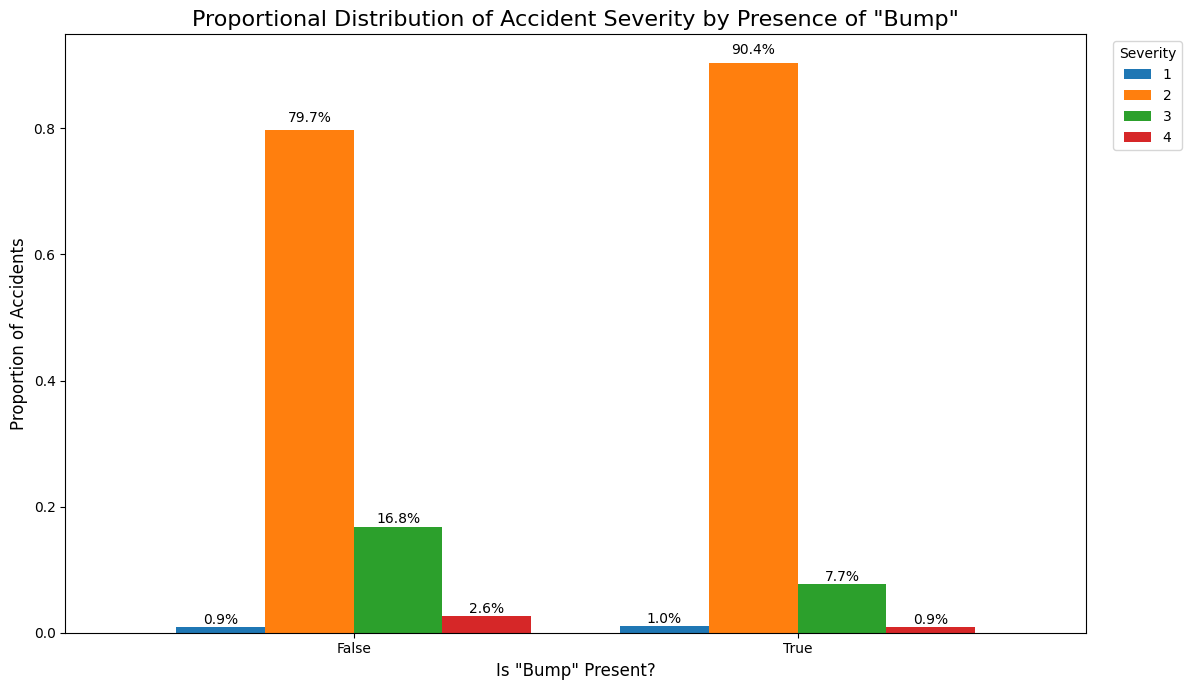

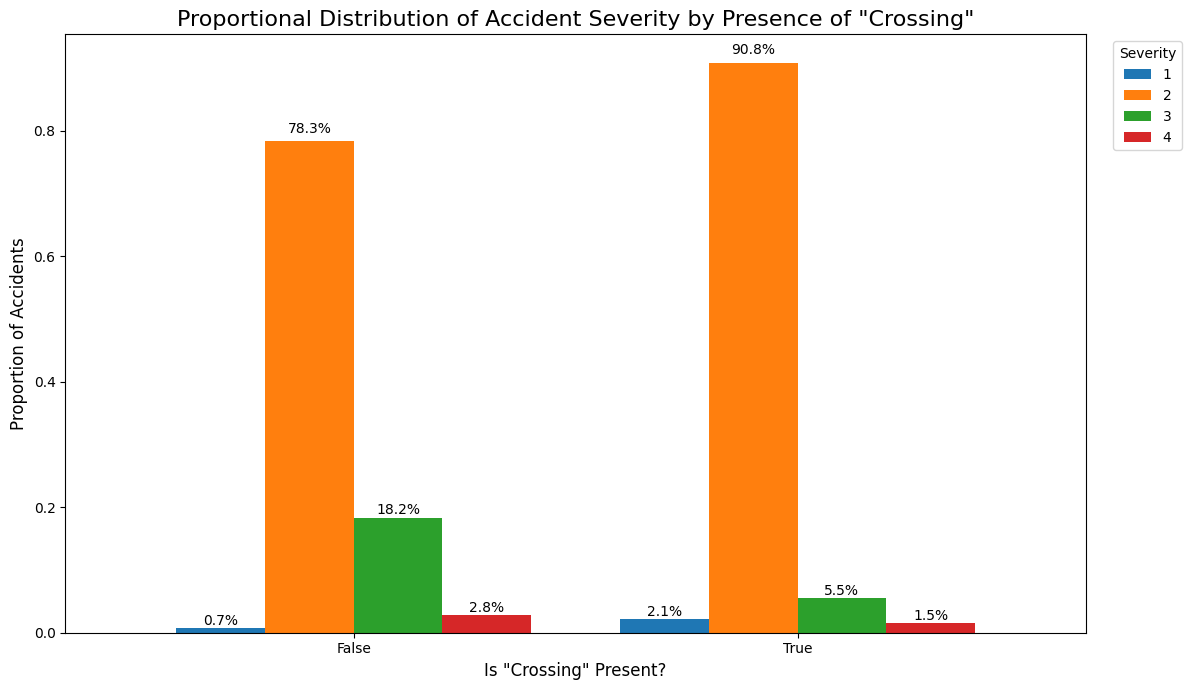

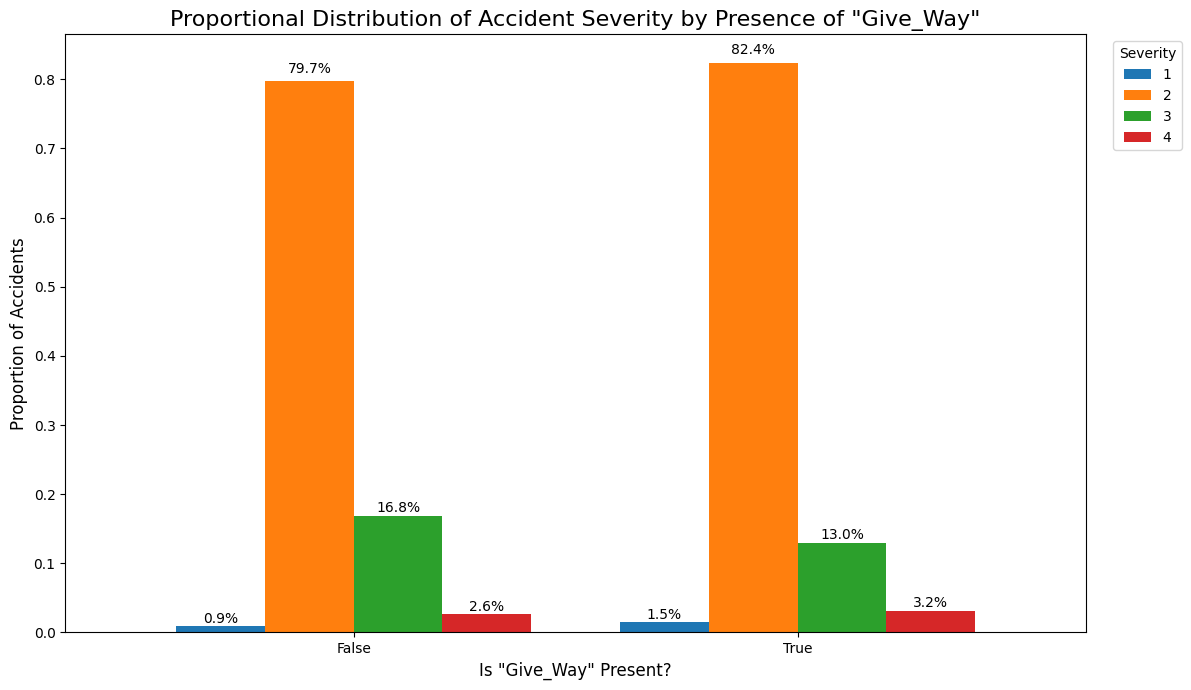

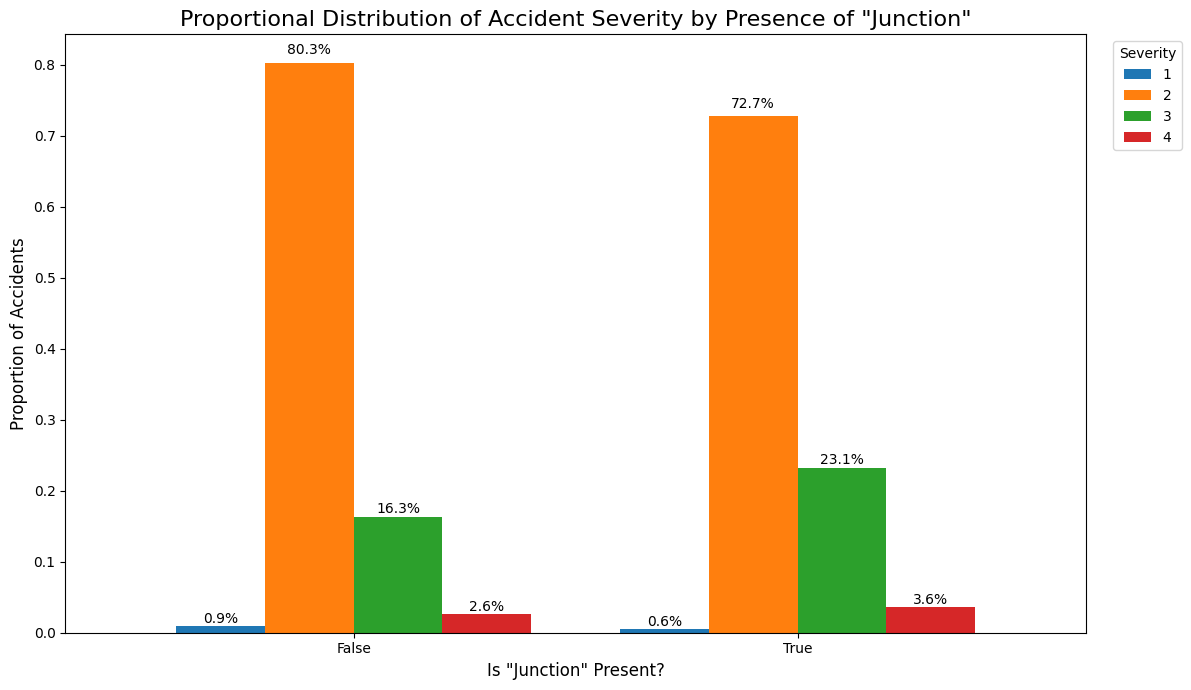

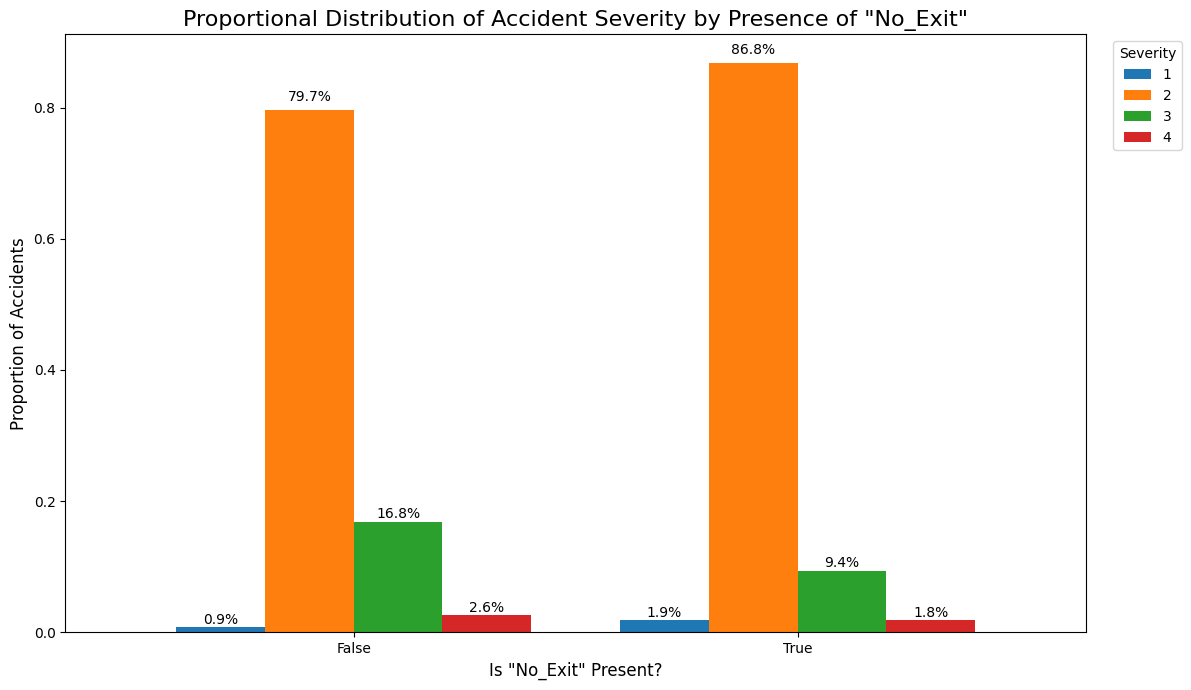

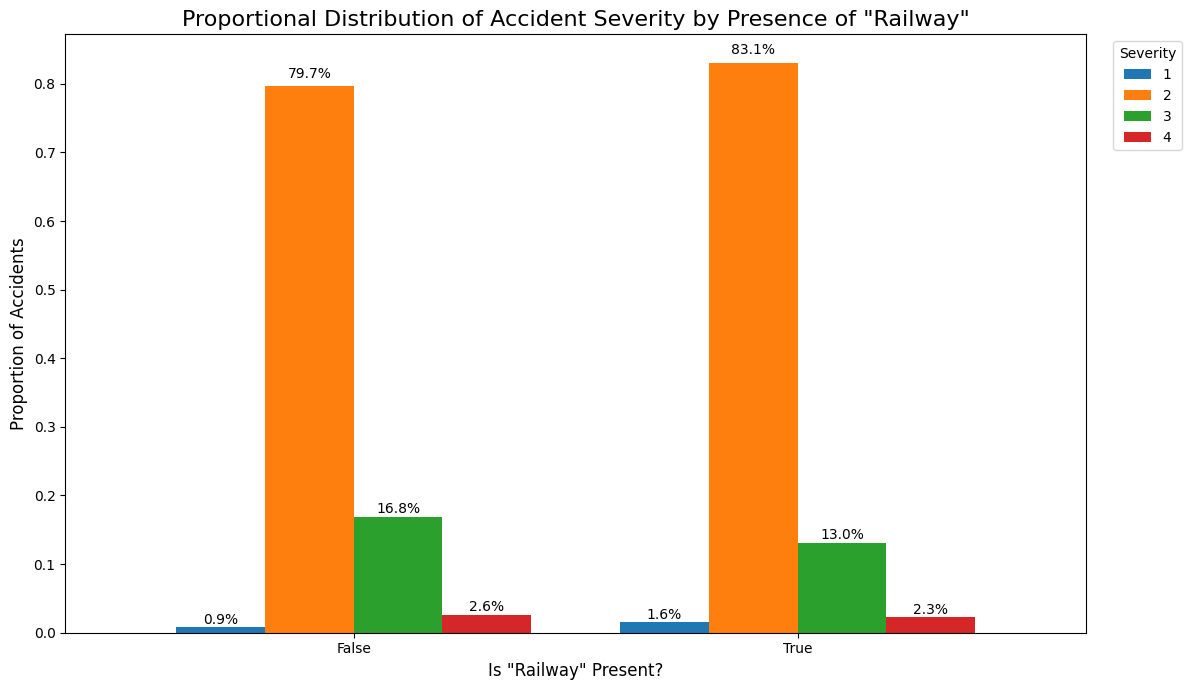

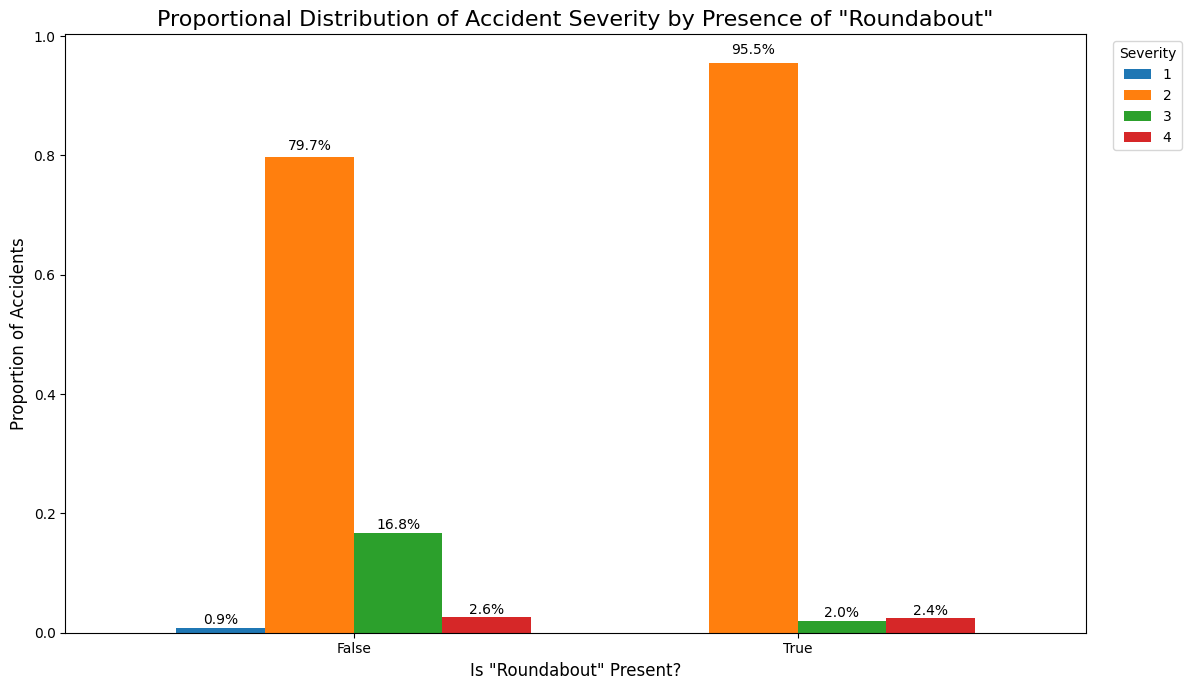

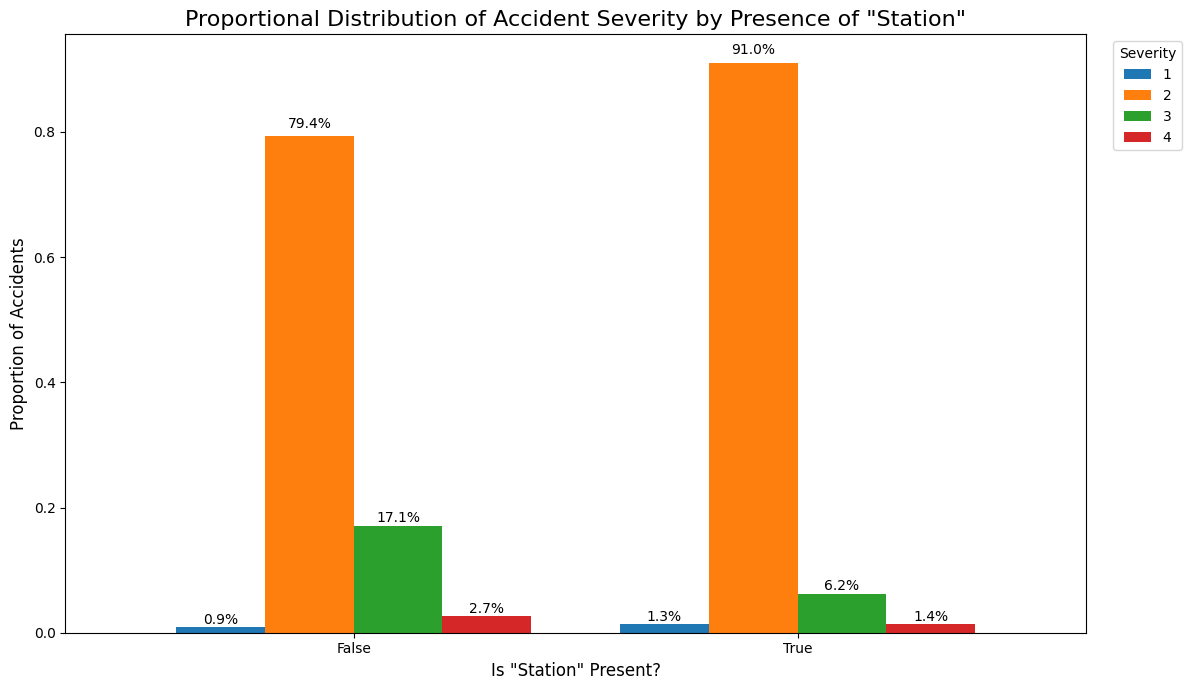

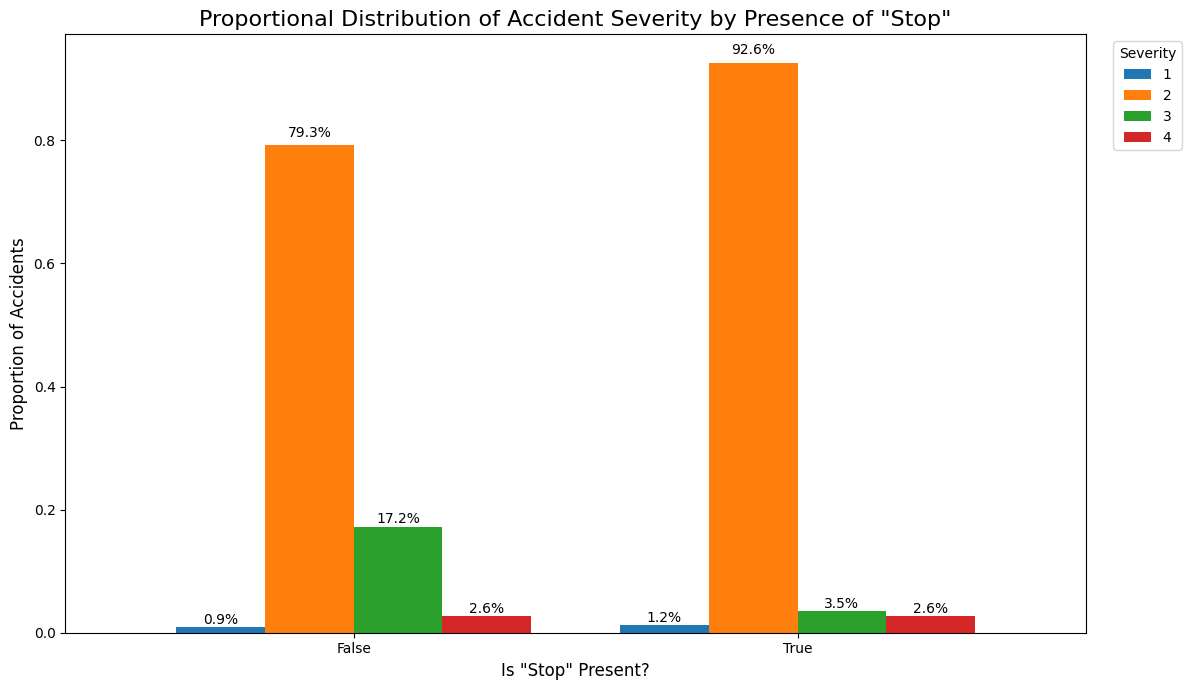

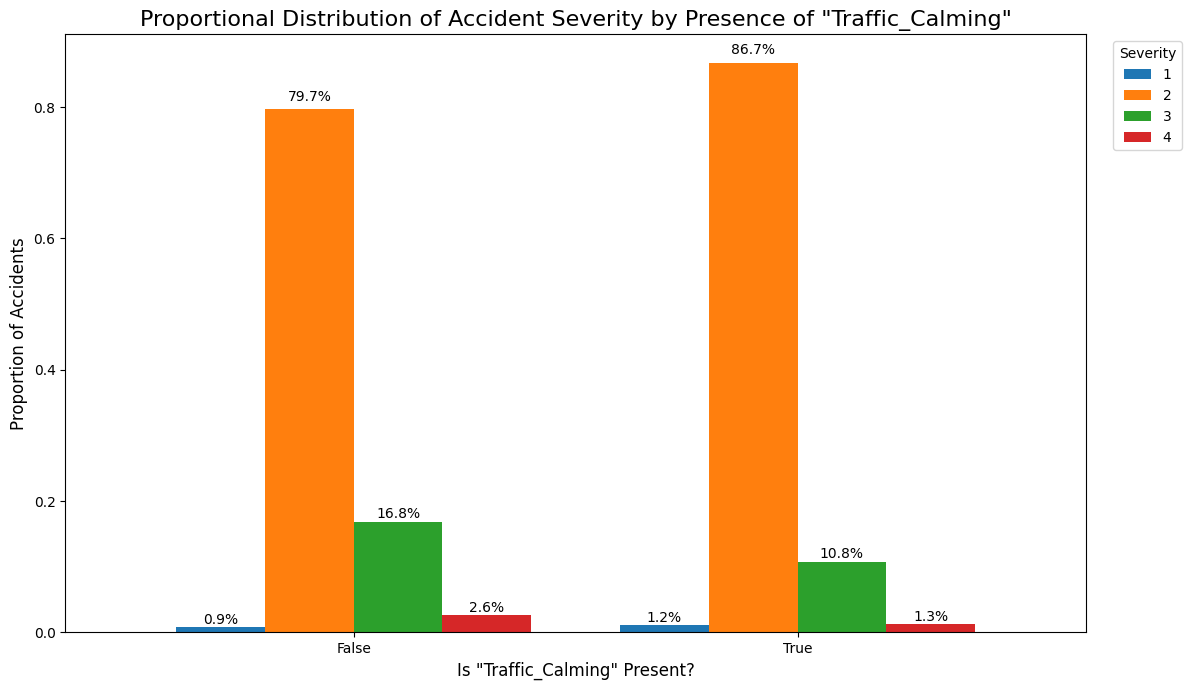

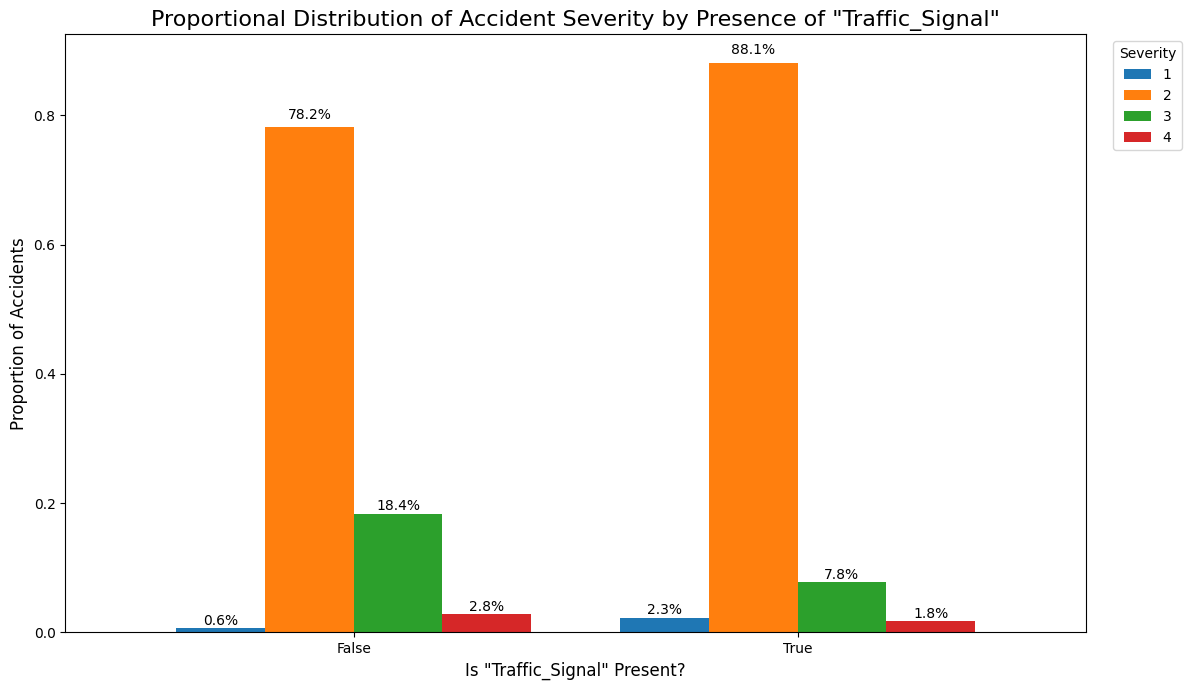

In [12]:
# Loop through each feature and create a plot
for feature in boolean_features:
    # Create a contingency table, normalized to show proportions
    crosstab = pd.crosstab(pdf[feature], pdf['Severity'], normalize='index')

    # Create the bar plot
    ax = crosstab.plot(kind='bar',
                      figsize=(12, 7),
                      rot=0,
                      width=0.8)

    # Set plot titles and labels for clarity
    plt.title(f'Proportional Distribution of Accident Severity by Presence of "{feature}"', fontsize=16)
    plt.xlabel(f'Is "{feature}" Present?', fontsize=12)
    plt.ylabel('Proportion of Accidents', fontsize=12)
    ax.set_xticklabels(['False', 'True'])
    plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Add percentage labels on top of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        if height > 0:
            x, y = p.get_xy()
            ax.text(x + width/2,
                    y + height*1.01,
                    f'{height:.1%}',
                    ha='center',
                    va='bottom')

    plt.tight_layout()
    plt.show()

In [13]:
pdf['Severity'].value_counts()

Severity
2    5994345
3    1262632
4     198840
1      65646
Name: count, dtype: int64

In [16]:
pdf['is_severity_4'] = (pdf['Severity'] == 4)

# Loop through each feature and run the test against the new binary target
results_sev4 = {}
for feature in boolean_features:
    # Create the 2x2 contingency table
    contingency_table = pd.crosstab(pdf[feature], pdf['is_severity_4'])
    
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    results_sev4[feature] = p

# 4. Display the results
results_sev4_df = pd.DataFrame.from_dict(results_sev4, orient='index', columns=['p-value'])
results_sev4_df['is_significant_at_0.05'] = results_sev4_df['p-value'] < 0.05

print("Chi-Square Test Results for 'Severity 4' vs. 'Others':")
print(results_sev4_df.sort_values(by='p-value'))

Chi-Square Test Results for 'Severity 4' vs. 'Others':
                       p-value  is_significant_at_0.05
Crossing          0.000000e+00                    True
Junction          0.000000e+00                    True
Traffic_Signal    0.000000e+00                    True
Station          6.876593e-278                    True
Traffic_Calming   2.323820e-12                    True
No_Exit           2.848573e-12                    True
Bump              5.557704e-10                    True
Give_Way          7.170269e-10                    True
Railway           1.765323e-07                    True
Stop              9.056907e-01                   False
Roundabout        9.989405e-01                   False


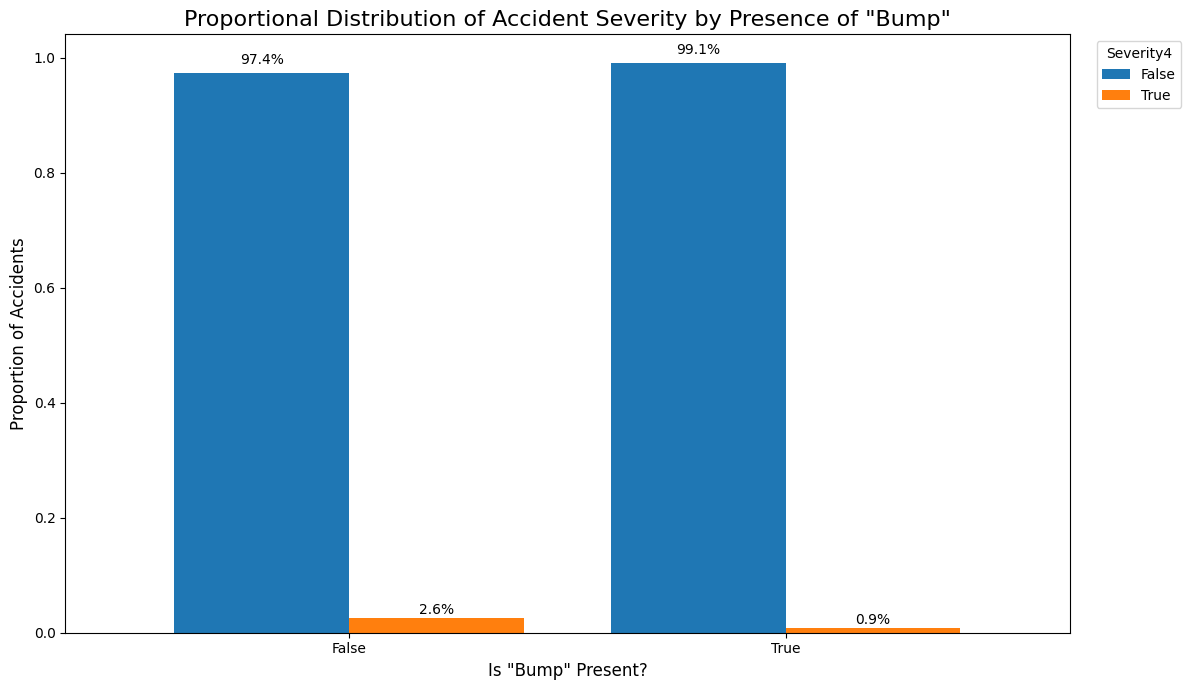

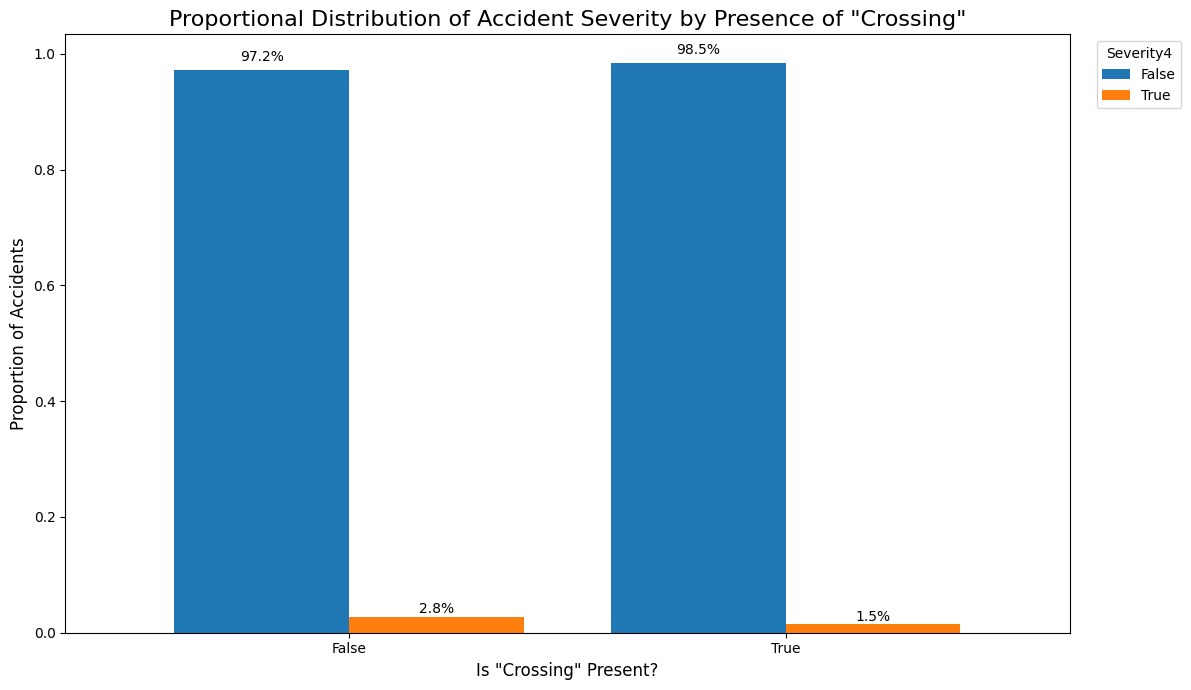

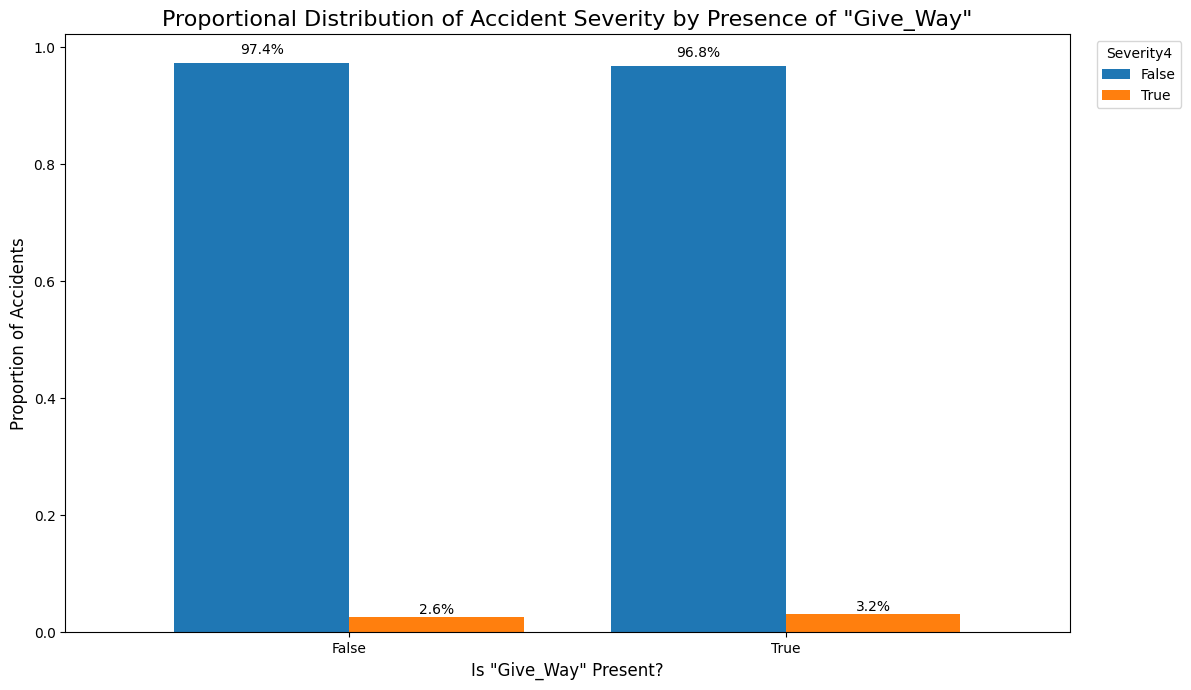

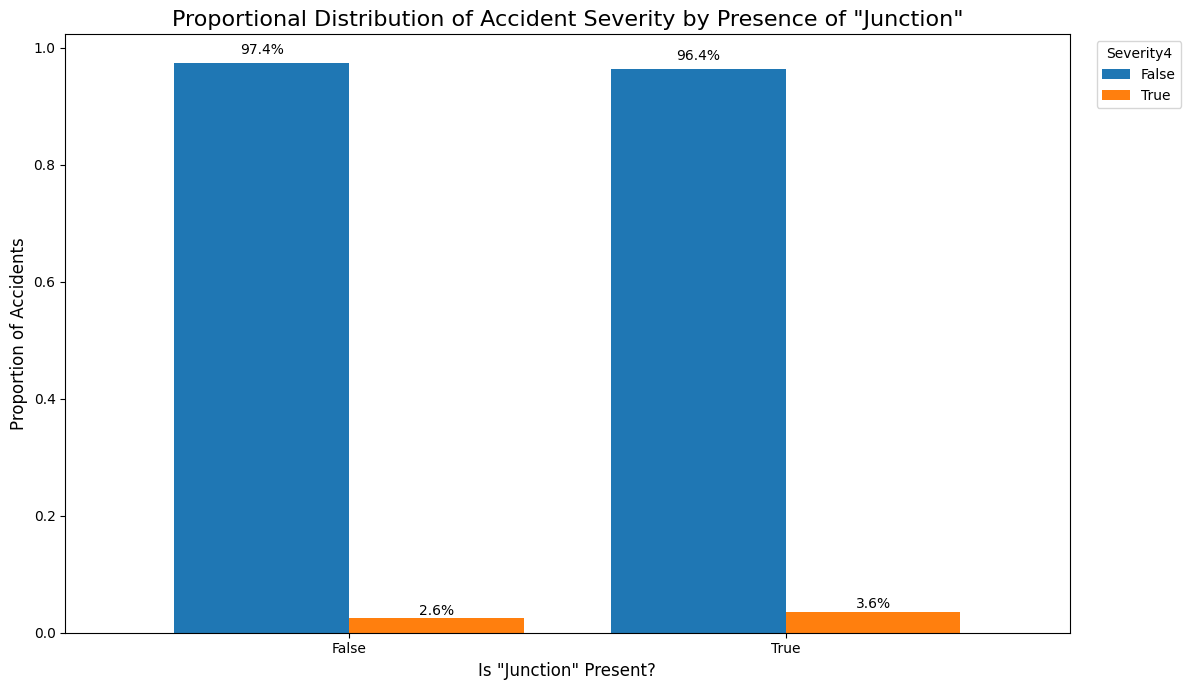

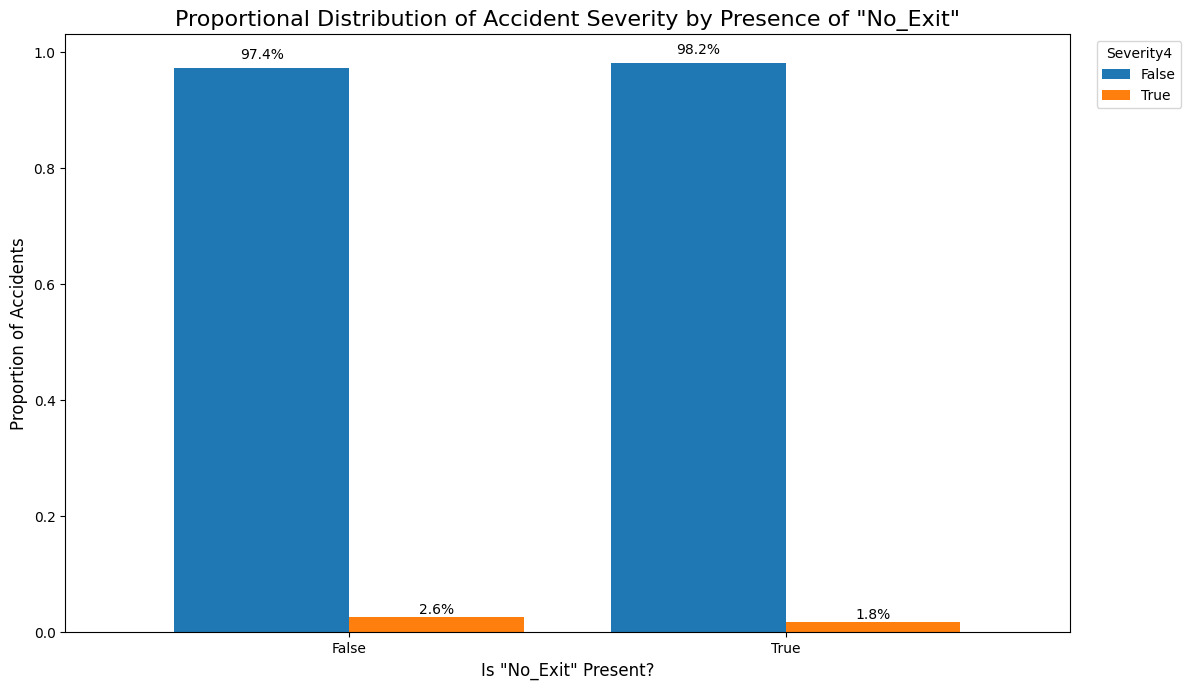

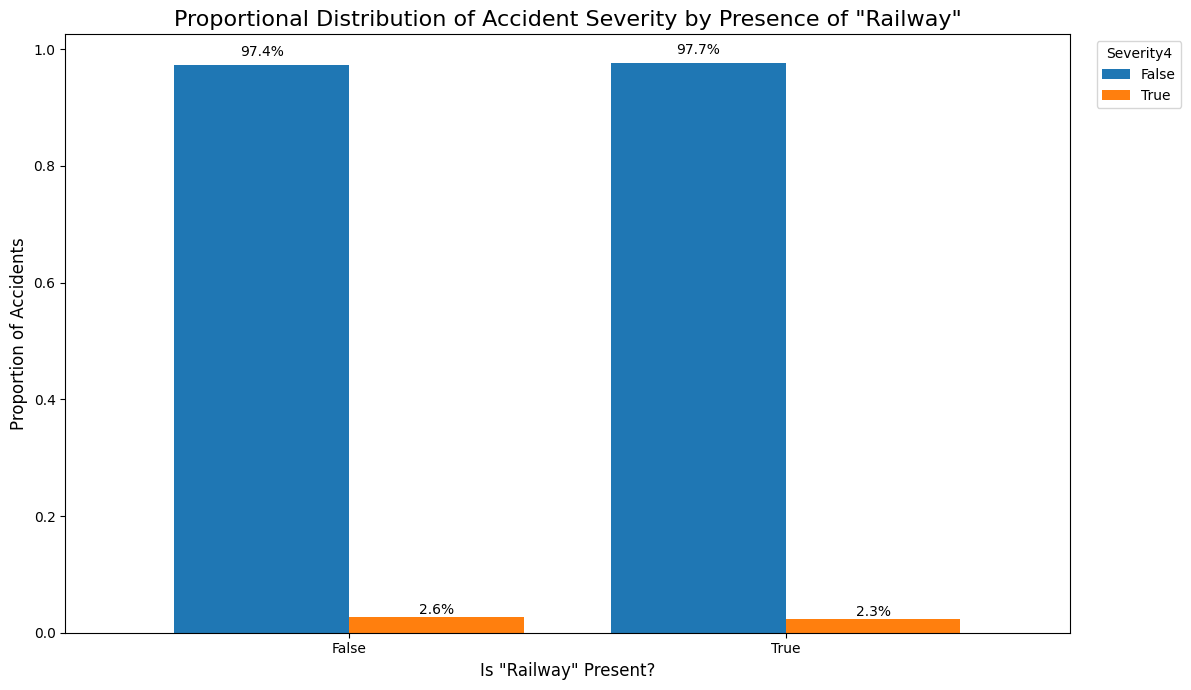

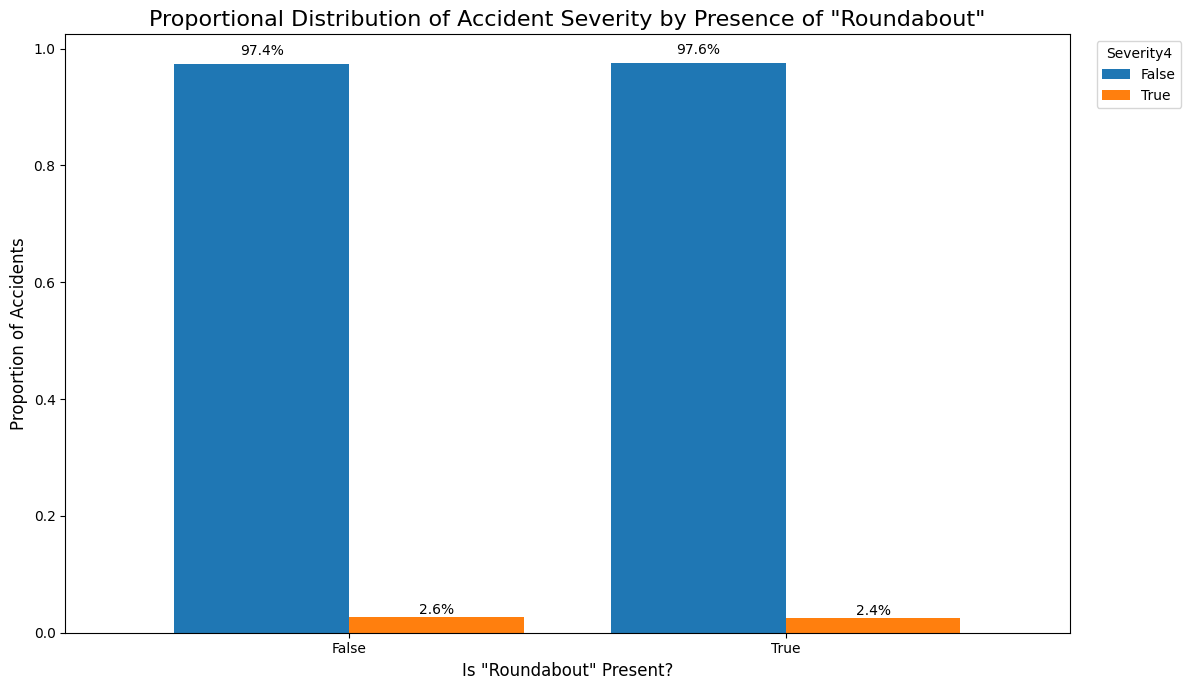

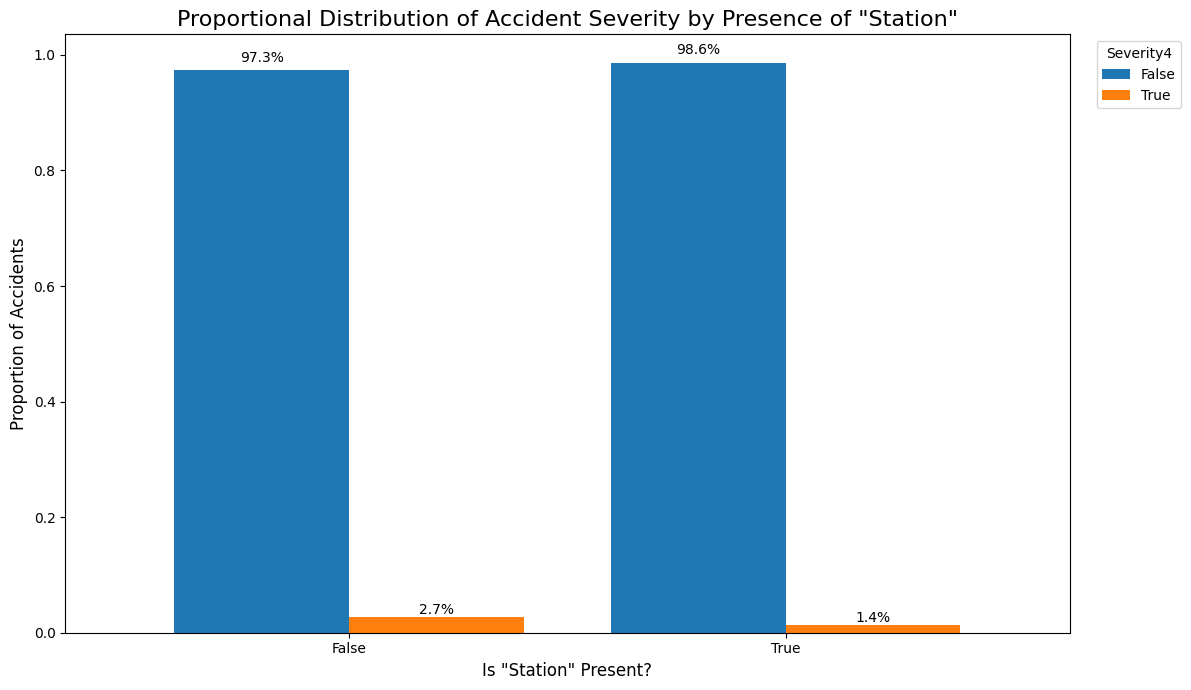

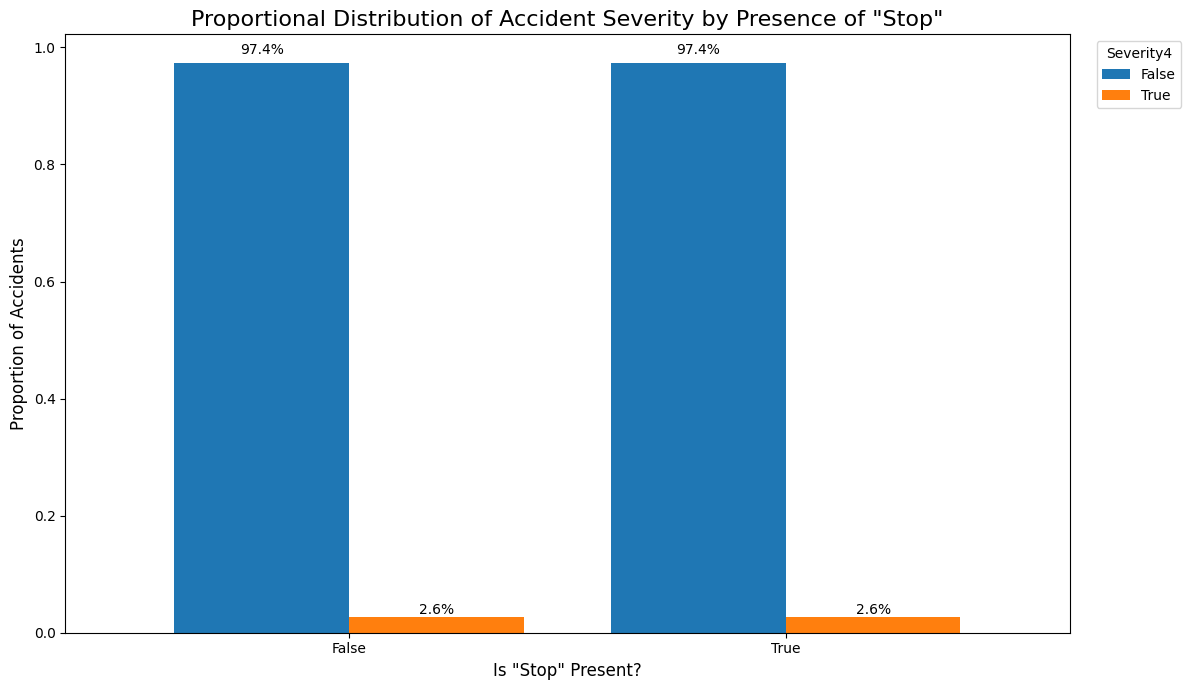

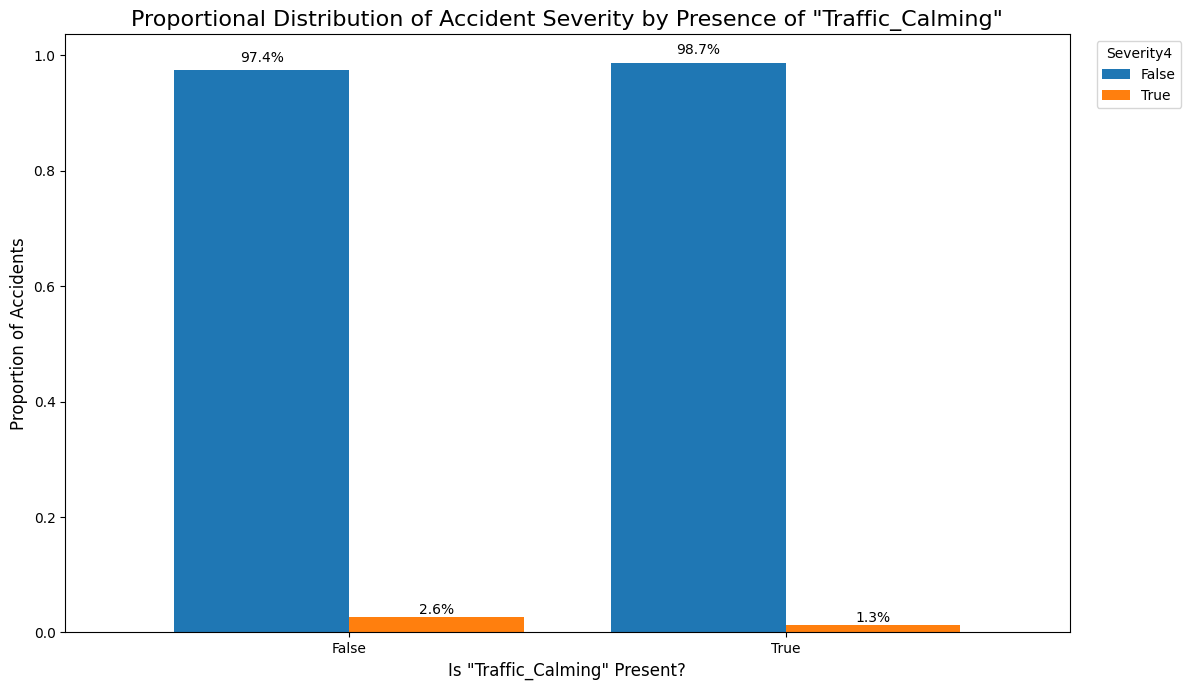

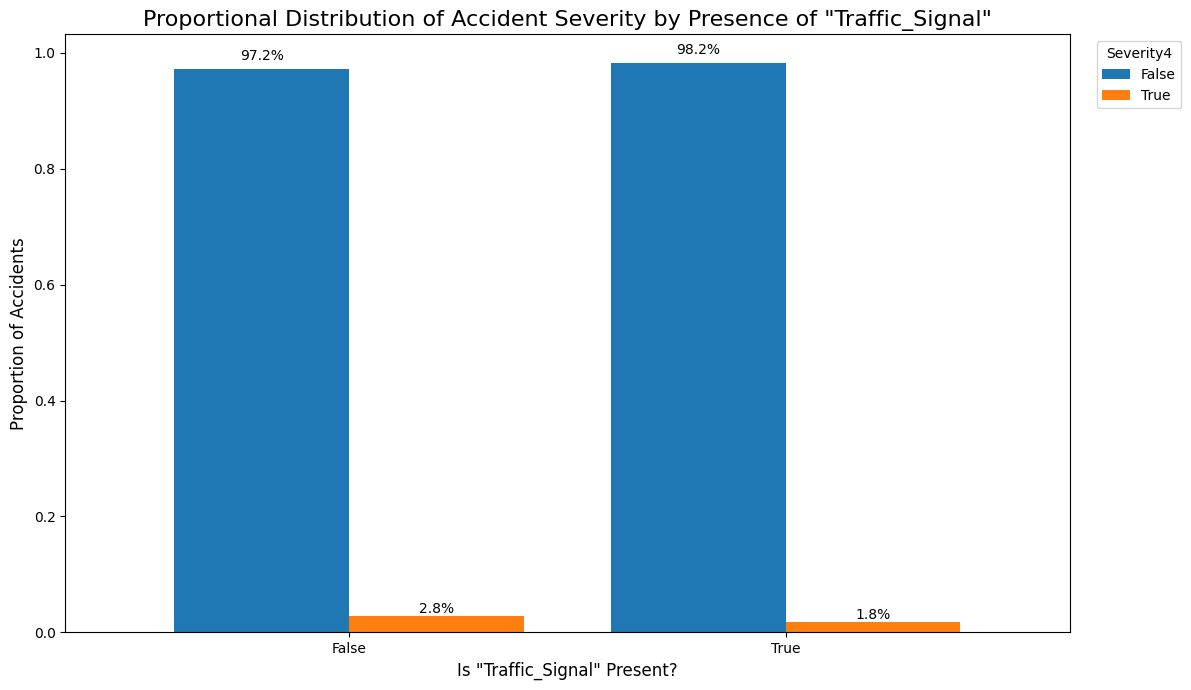

In [18]:
# Loop through each feature and create a plot
for feature in boolean_features:
    # Create a contingency table, normalized to show proportions
    crosstab = pd.crosstab(pdf[feature], pdf['is_severity_4'], normalize='index')

    # Create the bar plot
    ax = crosstab.plot(kind='bar',
                      figsize=(12, 7),
                      rot=0,
                      width=0.8)

    # Set plot titles and labels for clarity
    plt.title(f'Proportional Distribution of Accident Severity by Presence of "{feature}"', fontsize=16)
    plt.xlabel(f'Is "{feature}" Present?', fontsize=12)
    plt.ylabel('Proportion of Accidents', fontsize=12)
    ax.set_xticklabels(['False', 'True'])
    plt.legend(title='Severity4', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Add percentage labels on top of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        if height > 0:
            x, y = p.get_xy()
            ax.text(x + width/2,
                    y + height*1.01,
                    f'{height:.1%}',
                    ha='center',
                    va='bottom')

    plt.tight_layout()
    plt.show()

In [24]:
table_data = []

# Loop through each feature to get the proportions
for feature in boolean_features:
    # Create the crosstab, normalized by row
    crosstab = pd.crosstab(pdf[feature], pdf['is_severity_4'], normalize='index') * 100
    
    # Extract the percentages for Severity 4
    perc_when_false = crosstab.loc[False, True] if False in crosstab.index else 0
    perc_when_true = crosstab.loc[True, True] if True in crosstab.index else 0
    
    # Add the data to our list
    table_data.append({
        'Feature': feature,
        'Severity 4 % (When False)': perc_when_false,
        'Severity 4 % (When True)': perc_when_true
    })

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(table_data)

# Calculate the difference for easier interpretation
results_df['Difference'] = results_df['Severity 4 % (When True)'] - results_df['Severity 4 % (When False)']

# Sort by the absolute difference to see the most impactful features
results_df = results_df.sort_values(by='Difference', ascending=False, key=abs)


# Format the columns for better readability
results_df['Severity 4 % (When False)'] = results_df['Severity 4 % (When False)'].map('{:.2f}%'.format)
results_df['Severity 4 % (When True)'] = results_df['Severity 4 % (When True)'].map('{:.2f}%'.format)
results_df['Difference'] = results_df['Difference'].map('{:+.2f}%'.format)


print("Comparison of Severity 4 Accident Percentage:")
print(results_df.set_index('Feature'))

Comparison of Severity 4 Accident Percentage:
                Severity 4 % (When False) Severity 4 % (When True) Difference
Feature                                                                      
Bump                                2.64%                    0.90%     -1.74%
Traffic_Calming                     2.64%                    1.32%     -1.33%
Station                             2.68%                    1.37%     -1.31%
Crossing                            2.78%                    1.54%     -1.24%
Traffic_Signal                      2.80%                    1.76%     -1.04%
Junction                            2.57%                    3.60%     +1.04%
No_Exit                             2.65%                    1.83%     -0.82%
Give_Way                            2.64%                    3.17%     +0.53%
Railway                             2.65%                    2.32%     -0.33%
Roundabout                          2.64%                    2.44%     -0.20%
Stop              

Findings: 

While most road infrastructure features showed a significant relationship with accident severity overall, a more focused analysis revealed that stop signs and roundabouts have no statistically significant impact on whether an accident becomes a category 4 fatality.

This counterintuitive result suggests that while these measures are effective at reducing general accident frequency and lower-level severity, they do not mitigate the factors leading to the most severe outcomes. Conversely, features like traffic bumps, crossings, and traffic signals were found to be significant factors in reducing the likelihood of a category 4 accident, indicating their critical role in enhancing road safety at the highest level. This breakdown also highlighted the dangers of junctions, with over 1% increase in severity 4 occurance. 

# Weather

In [26]:
pdf['Weather_Category'].value_counts()

Weather_Category
Fair                2531988
Mostly Cloudy       1002239
Cloudy               812154
Clear                789605
Partly Cloudy        689511
Light Rain           394021
Overcast             372810
Other                226547
Scattered Clouds     199063
Fog                  196198
Rain                 174918
Light Snow           132409
Name: count, dtype: int64

In [25]:
# Create a contingency table
weather_contingency_table = pd.crosstab(pdf['Weather_Category'], pdf['Severity'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(weather_contingency_table)

print(f"Chi-Square Test for Weather_Category vs. Severity:")
print(f"P-value: {p}")

if p < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")

Chi-Square Test for Weather_Category vs. Severity:
P-value: 0.0
The relationship is statistically significant.


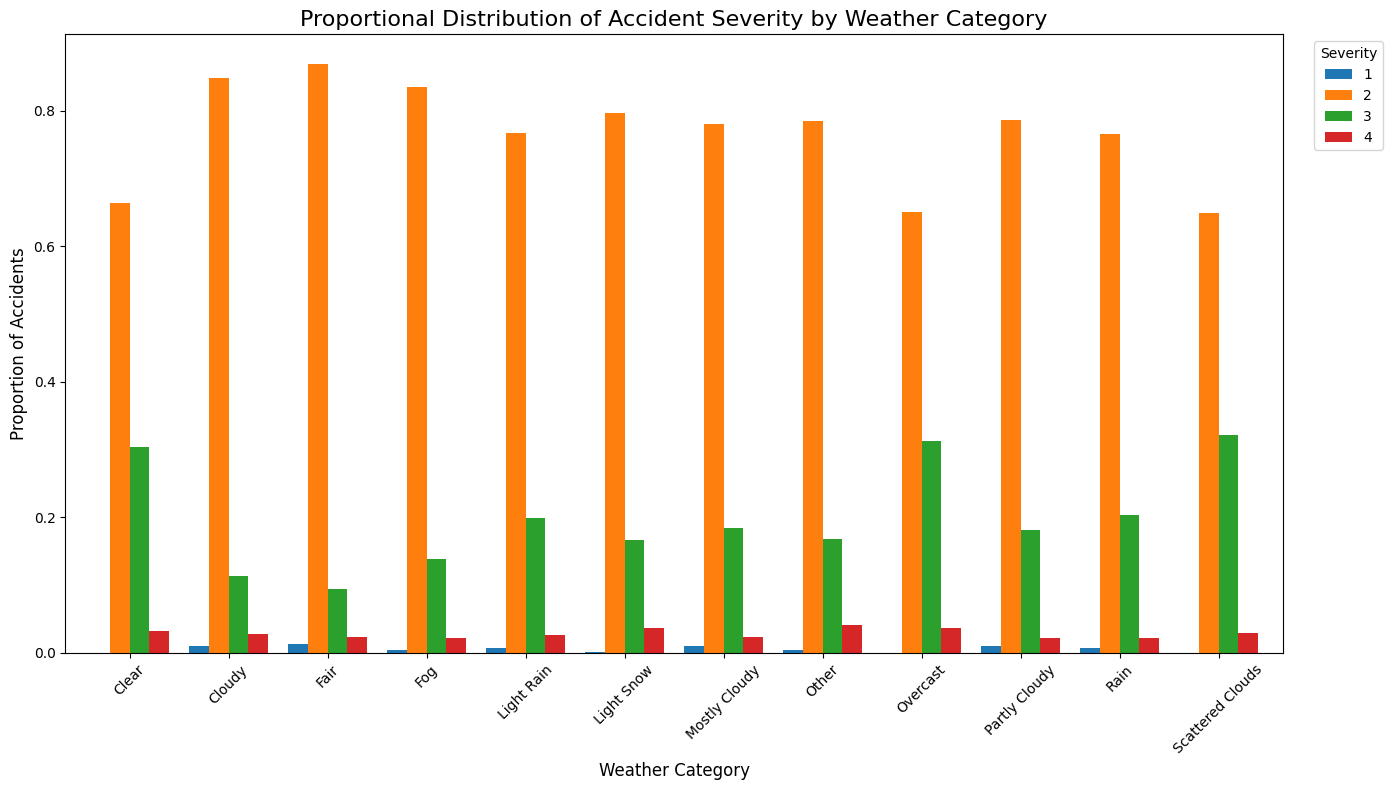

In [27]:
# Create the normalized crosstab
weather_crosstab_norm = pd.crosstab(pdf['Weather_Category'], pdf['Severity'], normalize='index')

# Plot the data
ax = weather_crosstab_norm.plot(kind='bar',
                                figsize=(14, 8),
                                rot=45,
                                width=0.8)

plt.title('Proportional Distribution of Accident Severity by Weather Category', fontsize=16)
plt.xlabel('Weather Category', fontsize=12)
plt.ylabel('Proportion of Accidents', fontsize=12)
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# 1. Create the contingency table for Weather_Category vs. is_severity_4
weather_contingency_table = pd.crosstab(pdf['Weather_Category'], pdf['is_severity_4'])

# 2. Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(weather_contingency_table)

# 3. Display the results
print("Chi-Square Test Results for 'Weather_Category' vs. 'Severity 4/Others':")
print(f"P-value: {p_value}")

# 4. Interpret the result
if p_value < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")

Chi-Square Test Results for 'Weather_Category' vs. 'Severity 4/Others':
P-value: 0.0
The relationship is statistically significant.


In [32]:
# Get a list of all unique weather categories
weather_categories = pdf['Weather_Category'].unique()

# List to hold the results for each category
weather_table_data = []

# Loop through each unique weather category
for category in weather_categories:
    
    # Calculate Severity 4 percentage FOR the current category
    is_category = (pdf['Weather_Category'] == category)
    perc_when_true = pdf.loc[is_category, 'is_severity_4'].mean() * 100

    # Calculate Severity 4 percentage for ALL OTHER categories combined
    perc_when_false = pdf.loc[~is_category, 'is_severity_4'].mean() * 100
    
    # Add the data to our list
    weather_table_data.append({
        'Weather Category': category,
        'Severity 4 % (All Other Weather)': perc_when_false,
        'Severity 4 % (This Weather)': perc_when_true
    })

# Convert the list to a DataFrame
weather_results_df = pd.DataFrame(weather_table_data)

# Calculate the difference to quantify the impact
weather_results_df['Difference'] = weather_results_df['Severity 4 % (This Weather)'] - weather_results_df['Severity 4 % (All Other Weather)']

# Sort by the absolute difference to find the most impactful weather conditions
weather_results_df = weather_results_df.sort_values(by='Difference', ascending=False)

# Format for readability
weather_results_df['Severity 4 % (All Other Weather)'] = weather_results_df['Severity 4 % (All Other Weather)'].map('{:.2f}%'.format)
weather_results_df['Severity 4 % (This Weather)'] = weather_results_df['Severity 4 % (This Weather)'].map('{:.2f}%'.format)
weather_results_df['Difference'] = weather_results_df['Difference'].map('{:+.2f}%'.format)

print("Comparison of Severity 4 Accident Percentage by Weather Category:")
weather_results_df.set_index('Weather Category')

Comparison of Severity 4 Accident Percentage by Weather Category:


,Severity 4 % (All Other Weather),Severity 4 % (This Weather),Difference
Weather Category,,,
Other,2.60%,4.15%,+1.56%
Light Snow,2.63%,3.66%,+1.04%
Overcast,2.59%,3.62%,+1.03%
Clear,2.57%,3.26%,+0.68%
Scattered Clouds,2.64%,2.91%,+0.27%
Cloudy,2.63%,2.79%,+0.16%
Light Rain,2.64%,2.69%,+0.05%
Mostly Cloudy,2.69%,2.32%,-0.37%
Rain,2.65%,2.28%,-0.37%


An examination of weather's impact on accident severity revealed a statistically significant relationship. Specifically, snowy and, surprisingly, overcast conditions showed the highest proportion of Category 4 accidents.

Notably, weather conditions like rain and fog were found to have a lower percentage of Severity 4 incidents than the average. This could be attributed to heightened driver awareness in visibly poor conditions. The "Other" weather category presented the largest deviation, indicating that a more granular breakdown of this category is necessary to uncover the specific, high-risk conditions it contains.

# Light Condition

In [33]:
pdf['Light_Condition'].value_counts()

Light_Condition
Light       5558732
Dark        1292292
Twilight     670439
Name: count, dtype: int64

In [34]:
# Create a contingency table
light_contingency_table = pd.crosstab(pdf['Light_Condition'], pdf['Severity'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(light_contingency_table)

print(f"Chi-Square Test for Light_Condition vs. Severity:")
print(f"P-value: {p}")

if p < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")

Chi-Square Test for Light_Condition vs. Severity:
P-value: 0.0
The relationship is statistically significant.


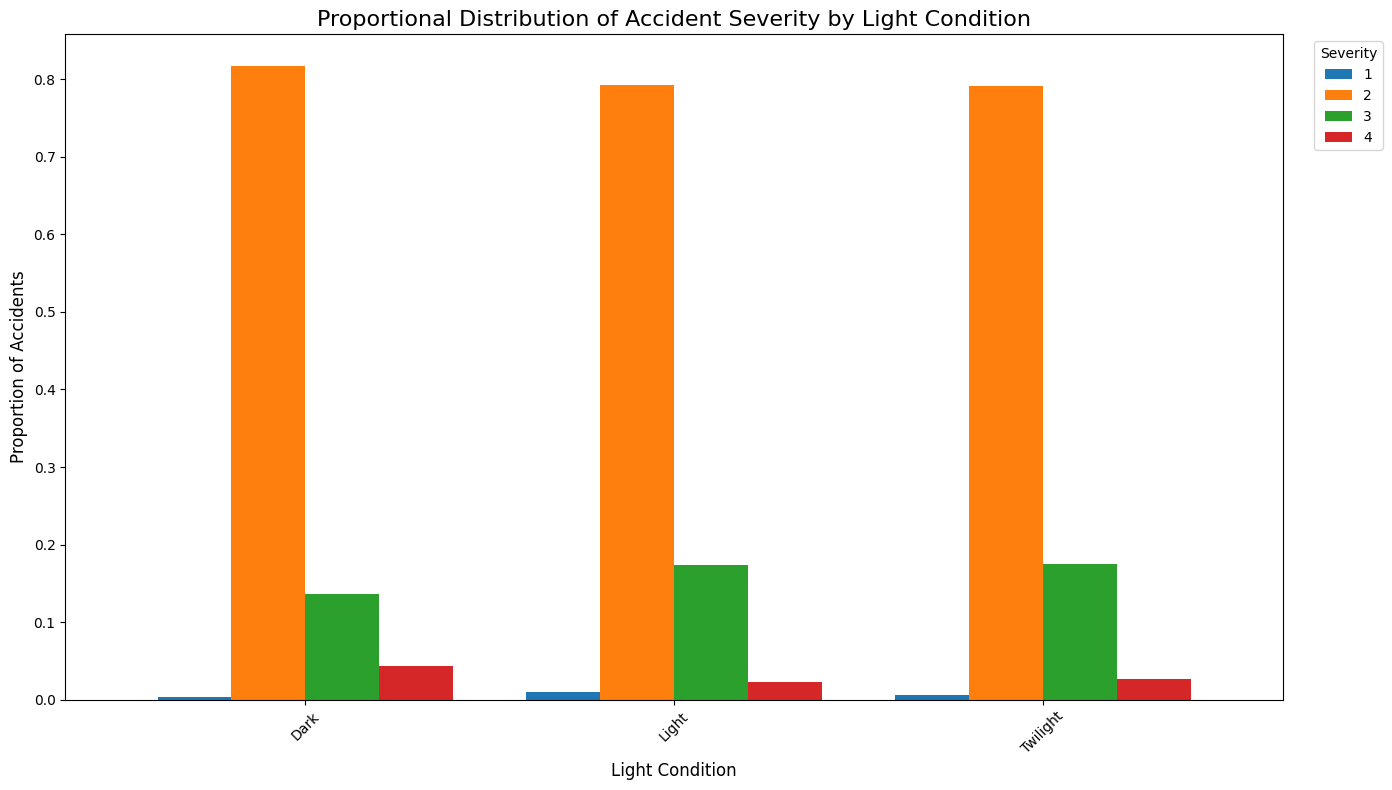

In [35]:
# Create the normalized crosstab
light_crosstab_norm = pd.crosstab(pdf['Light_Condition'], pdf['Severity'], normalize='index')

# Plot the data
ax = light_crosstab_norm.plot(kind='bar',
                                figsize=(14, 8),
                                rot=45,
                                width=0.8)

plt.title('Proportional Distribution of Accident Severity by Light Condition', fontsize=16)
plt.xlabel('Light Condition', fontsize=12)
plt.ylabel('Proportion of Accidents', fontsize=12)
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
# 1. Create the contingency table for Weather_Category vs. is_severity_4
light_contingency_table = pd.crosstab(pdf['Light_Condition'], pdf['is_severity_4'])

# 2. Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(light_contingency_table)

# 3. Display the results
print("Chi-Square Test Results for 'Light_Condition' vs. 'Severity 4/Others':")
print(f"P-value: {p_value}")

# 4. Interpret the result
if p_value < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")

Chi-Square Test Results for 'Light_Condition' vs. 'Severity 4/Others':
P-value: 0.0
The relationship is statistically significant.


In [38]:
# Get a list of all unique light categories
light_categories = pdf['Light_Condition'].unique()

# List to hold the results for each category
light_table_data = []

# Loop through each unique light category
for category in light_categories:
    
    # Calculate Severity 4 percentage FOR the current category
    is_category = (pdf['Light_Condition'] == category)
    perc_when_true = pdf.loc[is_category, 'is_severity_4'].mean() * 100

    # Calculate Severity 4 percentage for ALL OTHER categories combined
    perc_when_false = pdf.loc[~is_category, 'is_severity_4'].mean() * 100
    
    # Add the data to our list
    light_table_data.append({
        'Light Category': category,
        'Severity 4 % (All Other Light Conditions)': perc_when_false,
        'Severity 4 % (This Light Condition)': perc_when_true
    })

# Convert the list to a DataFrame
light_results_df = pd.DataFrame(light_table_data)

# Calculate the difference to quantify the impact
light_results_df['Difference'] = light_results_df['Severity 4 % (This Light Condition)'] - light_results_df['Severity 4 % (All Other Light Conditions)']

# Sort by the absolute difference to find the most impactful light conditions
light_results_df = light_results_df.sort_values(by='Difference', ascending=False)

# Format for readability
light_results_df['Severity 4 % (All Other Light Conditions)'] = light_results_df['Severity 4 % (All Other Light Conditions)'].map('{:.2f}%'.format)
light_results_df['Severity 4 % (This Light Condition)'] = light_results_df['Severity 4 % (This Light Condition)'].map('{:.2f}%'.format)
light_results_df['Difference'] = light_results_df['Difference'].map('{:+.2f}%'.format)

print("Comparison of Severity 4 Accident Percentage by Light Condition:")
light_results_df.set_index('Light Category')

Comparison of Severity 4 Accident Percentage by Light Condition:


,Severity 4 % (All Other Light Conditions),Severity 4 % (This Light Condition),Difference
Light Category,,,
Dark,2.30%,4.30%,+2.00%
Twilight,2.64%,2.67%,+0.03%
Light,3.74%,2.26%,-1.48%


The analysis clearly shows that darkness is a critical risk factor for severe accidents. Accidents occurring in the dark are associated with a 2.00% increase in the proportion of Category 4 fatalities compared to other light conditions.

Conversely, daylight appears to be a significant protective factor, showing a 1.48% decrease in the likelihood of a Severity 4 outcome. Twilight conditions showed a negligible effect. This strong correlation between visibility and accident severity points to a clear area for intervention.

## Evaluation

### Business Insight/Recommendation 1

The Finding: Analysis shows that while stop signs and roundabouts are effective for general safety, they do not significantly reduce the likelihood of a fatal (Category 4) accident. In contrast, features like traffic signals, designated crossings, and traffic bumps show a statistically significant association with a lower percentage of fatal accidents.

Recommendation: The DOT should re-evaluate its safety budget allocation to prioritize the installation and maintenance of traffic signals, well-marked crossings, and traffic calming bumps in high-risk areas, as these have a proven impact on reducing the most severe accidents. For new developments or road redesigns where a stop sign is being considered, a traffic signal should be the preferred alternative if conditions warrant.

### Business Insight/Recommendation 2

The Finding: Data highlights that the presence of a junction is associated with a more than 1% increase in the occurrence of Category 4 accidents, making them uniquely dangerous hotspots for severe incidents.

Recommendation: The DOT should launch a "Junction Safety Initiative" to conduct a systematic review of the most dangerous junctions identified in the dataset. This initiative should focus on implementing proven safety countermeasures at these specific locations, such as:

Improving visibility by clearing obstructions.

Adding dedicated turning lanes.

Upgrading to "smart" traffic signals that adapt to traffic flow.

Increasing the size and reflectivity of road signs.

### Business Insight/Recommendation 3

The Finding: Analysis reveals that the risk of a fatal (Category 4) accident is not uniform across all adverse conditions. Specifically, darkness and snowy conditions show the most significant increase in the proportion of severe accidents, while other conditions like rain or fog do not.

Recommendation: The DOT, in collaboration with emergency services dispatch centers, should develop and implement a dynamic, tiered alert system. This system would automatically elevate the readiness level of emergency responders based on real-time weather and light data, ensuring that resources are strategically allocated before an incident occurs. Prioritize prompt road salting after any snowfall, especially in areas that rarely experience winter weather. 

Tiered Alert Levels:

Level 1 (Standard Readiness): Normal operating conditions.

Level 2 (Heightened Alert): Automatically triggered during darkness (from sunset to sunrise).

Level 3 (Maximum Alert): Automatically triggered during periods of snowfall, especially when combined with darkness. This could involve pre-deploying specialized vehicles to key highway interchanges or known trouble spots.

##### Creating csv for tableau dashboard

In [41]:
pdf.columns

Index(['Airport_Code', 'Severity', 'Distance(mi)', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Start_Time_clean',
       'Weather_Category', 'Light_Condition', 'CODE2023', 'DayOfWeek', 'Month',
       'Hour', 'DayOfWeek_num', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Hour_sin',
       'Hour_cos', 'Month_num', 'Month_sin', 'Month_cos', 'is_severity_4'],
      dtype='object')

In [44]:
results_df.to_csv('results_df.csv', index=False)
weather_results_df.to_csv('weather_results_df.csv', index=False)
light_results_df.to_csv('light_results_df.csv', index=False)

### https://public.tableau.com/shared/25JJ2DHD3?:display_count=n&:origin=viz_share_link

## Conclusion and Next Steps
Conclusion: This analysis demonstrates that a targeted, data-driven approach can uncover specific, sometimes counterintuitive, insights to significantly improve road safety.

Next Steps:

Conduct a granular analysis of the "Other" weather category to identify specific high-risk conditions.

Develop a location-based risk model to identify specific high-risk road segments and intersections for proactive intervention.

Integrate traffic volume data to analyze accident rates, not just counts.